In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'VTCNN2_v2_iq_mp'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return modules, phases

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","([0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","([0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","([0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","([0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","([0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","([0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","([0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","([0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","([0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = []

for i in range(0, len(dataset_df.index)):
    signal = []
    signal.append(dataset_df[iq_signals_column_dataframe_name][i][0])
    signal.append(dataset_df[iq_signals_column_dataframe_name][i][1])
    signal.append(dataset_df[module_phase_signals_column_dataframe_name][i][0])
    signal.append(dataset_df[module_phase_signals_column_dataframe_name][i][1])
    signals.append(signal)

labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 4, 128)
[4, 128]


In [16]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 4, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 8, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 3, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 3, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 7, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 3, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 3, 80)          0

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 31:17 - loss: 2.3978

  7/151 [>.............................] - ETA: 1s - loss: 2.3977   

 13/151 [=>............................] - ETA: 1s - loss: 2.3975

 20/151 [==>...........................] - ETA: 1s - loss: 2.3969

 27/151 [====>.........................] - ETA: 1s - loss: 2.3957

 34/151 [=====>........................] - ETA: 0s - loss: 2.3933

 41/151 [=======>......................] - ETA: 0s - loss: 2.3892

 48/151 [========>.....................] - ETA: 0s - loss: 2.3838

 55/151 [=========>....................] - ETA: 0s - loss: 2.3781

 62/151 [===========>..................] - ETA: 0s - loss: 2.3725

 69/151 [============>.................] - ETA: 0s - loss: 2.3671

 76/151 [==============>...............] - ETA: 0s - loss: 2.3621

 83/151 [===============>..............] - ETA: 0s - loss: 2.3574

 90/151 [================>.............] - ETA: 0s - loss: 2.3531



 97/151 [==================>...........] - ETA: 0s - loss: 2.3490

104/151 [===================>..........] - ETA: 0s - loss: 2.3453

111/151 [=====================>........] - ETA: 0s - loss: 2.3417

118/151 [======================>.......] - ETA: 0s - loss: 2.3384

125/151 [=======================>......] - ETA: 0s - loss: 2.3353

132/151 [=========================>....] - ETA: 0s - loss: 2.3323

139/151 [==========================>...] - ETA: 0s - loss: 2.3295

146/151 [============================>.] - ETA: 0s - loss: 2.3269

151/151 [==============================] - ETA: 0s - loss: 2.3251

151/151 [==============================] - 14s 12ms/step - loss: 2.3248 - val_loss: 2.2126


Epoch 2/100
  1/151 [..............................] - ETA: 1s - loss: 2.2249

  8/151 [>.............................] - ETA: 1s - loss: 2.2302

 15/151 [=>............................] - ETA: 1s - loss: 2.2297

 22/151 [===>..........................] - ETA: 1s - loss: 2.2286

 29/151 [====>.........................] - ETA: 0s - loss: 2.2280

 36/151 [======>.......................] - ETA: 0s - loss: 2.2271

 43/151 [=======>......................] - ETA: 0s - loss: 2.2261

 50/151 [========>.....................] - ETA: 0s - loss: 2.2250

 57/151 [==========>...................] - ETA: 0s - loss: 2.2240

 64/151 [===========>..................] - ETA: 0s - loss: 2.2229



 71/151 [=============>................] - ETA: 0s - loss: 2.2217

 78/151 [==============>...............] - ETA: 0s - loss: 2.2205

 85/151 [===============>..............] - ETA: 0s - loss: 2.2192

 92/151 [=================>............] - ETA: 0s - loss: 2.2177

 99/151 [==================>...........] - ETA: 0s - loss: 2.2161

106/151 [====================>.........] - ETA: 0s - loss: 2.2144

113/151 [=====================>........] - ETA: 0s - loss: 2.2126

120/151 [======================>.......] - ETA: 0s - loss: 2.2106

127/151 [========================>.....] - ETA: 0s - loss: 2.2085

134/151 [=========================>....] - ETA: 0s - loss: 2.2064

141/151 [===========================>..] - ETA: 0s - loss: 2.2041

148/151 [============================>.] - ETA: 0s - loss: 2.2019

151/151 [==============================] - 1s 9ms/step - loss: 2.2006 - val_loss: 1.9960


Epoch 3/100
  1/151 [..............................] - ETA: 1s - loss: 2.0324

  8/151 [>.............................] - ETA: 1s - loss: 2.0298

 15/151 [=>............................] - ETA: 1s - loss: 2.0344

 22/151 [===>..........................] - ETA: 1s - loss: 2.0342

 30/151 [====>.........................] - ETA: 0s - loss: 2.0329

 37/151 [======>.......................] - ETA: 0s - loss: 2.0319

 44/151 [=======>......................] - ETA: 0s - loss: 2.0310

 51/151 [=========>....................] - ETA: 0s - loss: 2.0302

 58/151 [==========>...................] - ETA: 0s - loss: 2.0296

 65/151 [===========>..................] - ETA: 0s - loss: 2.0289

 72/151 [=============>................] - ETA: 0s - loss: 2.0281

 79/151 [==============>...............] - ETA: 0s - loss: 2.0272

 86/151 [================>.............] - ETA: 0s - loss: 2.0264

 93/151 [=================>............] - ETA: 0s - loss: 2.0255

100/151 [==================>...........] - ETA: 0s - loss: 2.0247

107/151 [====================>.........] - ETA: 0s - loss: 2.0239

114/151 [=====================>........] - ETA: 0s - loss: 2.0230

121/151 [=======================>......] - ETA: 0s - loss: 2.0222

128/151 [========================>.....] - ETA: 0s - loss: 2.0214

135/151 [=========================>....] - ETA: 0s - loss: 2.0206



142/151 [===========================>..] - ETA: 0s - loss: 2.0198

149/151 [============================>.] - ETA: 0s - loss: 2.0190

151/151 [==============================] - 1s 9ms/step - loss: 2.0187 - val_loss: 1.9080


Epoch 4/100
  1/151 [..............................] - ETA: 1s - loss: 1.9717

  8/151 [>.............................] - ETA: 1s - loss: 1.9739

 15/151 [=>............................] - ETA: 1s - loss: 1.9750

 22/151 [===>..........................] - ETA: 1s - loss: 1.9723

 29/151 [====>.........................] - ETA: 0s - loss: 1.9696

 36/151 [======>.......................] - ETA: 0s - loss: 1.9673

 43/151 [=======>......................] - ETA: 0s - loss: 1.9651

 50/151 [========>.....................] - ETA: 0s - loss: 1.9633

 57/151 [==========>...................] - ETA: 0s - loss: 1.9618

 64/151 [===========>..................] - ETA: 0s - loss: 1.9605

 71/151 [=============>................] - ETA: 0s - loss: 1.9594

 78/151 [==============>...............] - ETA: 0s - loss: 1.9583

 85/151 [===============>..............] - ETA: 0s - loss: 1.9573

 92/151 [=================>............] - ETA: 0s - loss: 1.9563

 99/151 [==================>...........] - ETA: 0s - loss: 1.9553

106/151 [====================>.........] - ETA: 0s - loss: 1.9543

113/151 [=====================>........] - ETA: 0s - loss: 1.9534

120/151 [======================>.......] - ETA: 0s - loss: 1.9525

127/151 [========================>.....] - ETA: 0s - loss: 1.9516

134/151 [=========================>....] - ETA: 0s - loss: 1.9509

141/151 [===========================>..] - ETA: 0s - loss: 1.9501

148/151 [============================>.] - ETA: 0s - loss: 1.9493

151/151 [==============================] - 1s 9ms/step - loss: 1.9489 - val_loss: 1.8346


Epoch 5/100
  1/151 [..............................] - ETA: 1s - loss: 1.9386

  8/151 [>.............................] - ETA: 1s - loss: 1.9185



 15/151 [=>............................] - ETA: 1s - loss: 1.9147

 22/151 [===>..........................] - ETA: 0s - loss: 1.9141

 29/151 [====>.........................] - ETA: 0s - loss: 1.9123

 36/151 [======>.......................] - ETA: 0s - loss: 1.9112

 43/151 [=======>......................] - ETA: 0s - loss: 1.9096

 50/151 [========>.....................] - ETA: 0s - loss: 1.9080

 57/151 [==========>...................] - ETA: 0s - loss: 1.9066

 64/151 [===========>..................] - ETA: 0s - loss: 1.9053

 71/151 [=============>................] - ETA: 0s - loss: 1.9041

 78/151 [==============>...............] - ETA: 0s - loss: 1.9032

 85/151 [===============>..............] - ETA: 0s - loss: 1.9024

 92/151 [=================>............] - ETA: 0s - loss: 1.9016

 99/151 [==================>...........] - ETA: 0s - loss: 1.9010

106/151 [====================>.........] - ETA: 0s - loss: 1.9003

113/151 [=====================>........] - ETA: 0s - loss: 1.8998

120/151 [======================>.......] - ETA: 0s - loss: 1.8992

127/151 [========================>.....] - ETA: 0s - loss: 1.8986

134/151 [=========================>....] - ETA: 0s - loss: 1.8981

141/151 [===========================>..] - ETA: 0s - loss: 1.8976

148/151 [============================>.] - ETA: 0s - loss: 1.8972

151/151 [==============================] - 1s 9ms/step - loss: 1.8969 - val_loss: 1.8102


Epoch 6/100
  1/151 [..............................] - ETA: 1s - loss: 1.8860

  8/151 [>.............................] - ETA: 1s - loss: 1.8673

 15/151 [=>............................] - ETA: 1s - loss: 1.8662

 22/151 [===>..........................] - ETA: 0s - loss: 1.8682

 29/151 [====>.........................] - ETA: 0s - loss: 1.8690

 36/151 [======>.......................] - ETA: 0s - loss: 1.8688

 43/151 [=======>......................] - ETA: 0s - loss: 1.8685

 50/151 [========>.....................] - ETA: 0s - loss: 1.8684

 57/151 [==========>...................] - ETA: 0s - loss: 1.8683

 64/151 [===========>..................] - ETA: 0s - loss: 1.8683

 71/151 [=============>................]

 - ETA: 0s - loss: 1.8681

 78/151 [==============>...............] - ETA: 0s - loss: 1.8680

 85/151 [===============>..............] - ETA: 0s - loss: 1.8678

 92/151 [=================>............] - ETA: 0s - loss: 1.8676

 99/151 [==================>...........] - ETA: 0s - loss: 1.8673

106/151 [====================>.........] - ETA: 0s - loss: 1.8671

113/151 [=====================>........] - ETA: 0s - loss: 1.8669

120/151 [======================>.......] - ETA: 0s - loss: 1.8668

127/151 [========================>.....] - ETA: 0s - loss: 1.8667

134/151 [=========================>....] - ETA: 0s - loss: 1.8665

141/151 [===========================>..] - ETA: 0s - loss: 1.8664

148/151 [============================>.] - ETA: 0s - loss: 1.8662

151/151 [==============================] - 1s 9ms/step - loss: 1.8662 - val_loss: 1.7827


Epoch 7/100
  1/151 [..............................] - ETA: 1s - loss: 1.8554

  8/151 [>.............................] - ETA: 1s - loss: 1.8574

 15/151 [=>............................] - ETA: 1s - loss: 1.8521

 22/151 [===>..........................] - ETA: 1s - loss: 1.8495

 29/151 [====>.........................] - ETA: 0s - loss: 1.8485

 36/151 [======>.......................] - ETA: 0s - loss: 1.8483

 43/151 [=======>......................] - ETA: 0s - loss: 1.8487

 50/151 [========>.....................] - ETA: 0s - loss: 1.8490

 57/151 [==========>...................] - ETA: 0s - loss: 1.8493

 64/151 [===========>..................] - ETA: 0s - loss: 1.8495

 71/151 [=============>................] - ETA: 0s - loss: 1.8496

 78/151 [==============>...............] - ETA: 0s - loss: 1.8496

 85/151 [===============>..............] - ETA: 0s - loss: 1.8496

 92/151 [=================>............] - ETA: 0s - loss: 1.8496

 99/151 [==================>...........] - ETA: 0s - loss: 1.8495

106/151 [====================>.........] - ETA: 0s - loss: 1.8495

113/151 [=====================>........] - ETA: 0s - loss: 1.8494

120/151 [======================>.......] - ETA: 0s - loss: 1.8494



127/151 [========================>.....] - ETA: 0s - loss: 1.8494

134/151 [=========================>....] - ETA: 0s - loss: 1.8493

141/151 [===========================>..] - ETA: 0s - loss: 1.8492

148/151 [============================>.] - ETA: 0s - loss: 1.8492

151/151 [==============================] - 1s 9ms/step - loss: 1.8491 - val_loss: 1.7680


Epoch 8/100
  1/151 [..............................] - ETA: 1s - loss: 1.8258

  8/151 [>.............................] - ETA: 1s - loss: 1.8368

 15/151 [=>............................] - ETA: 1s - loss: 1.8344

 22/151 [===>..........................] - ETA: 1s - loss: 1.8344

 29/151 [====>.........................] - ETA: 0s - loss: 1.8345

 36/151 [======>.......................] - ETA: 0s - loss: 1.8345

 43/151 [=======>......................] - ETA: 0s - loss: 1.8343

 50/151 [========>.....................] - ETA: 0s - loss: 1.8343

 57/151 [==========>...................] - ETA: 0s - loss: 1.8341

 64/151 [===========>..................] - ETA: 0s - loss: 1.8339

 71/151 [=============>................] - ETA: 0s - loss: 1.8339

 78/151 [==============>...............] - ETA: 0s - loss: 1.8339

 85/151 [===============>..............] - ETA: 0s - loss: 1.8339

 92/151 [=================>............] - ETA: 0s - loss: 1.8339

 99/151 [==================>...........] - ETA: 0s - loss: 1.8339

106/151 [====================>.........] - ETA: 0s - loss: 1.8339

113/151 [=====================>........] - ETA: 0s - loss: 1.8340

120/151 [======================>.......] - ETA: 0s - loss: 1.8340

127/151 [========================>.....] - ETA: 0s - loss: 1.8340

134/151 [=========================>....] - ETA: 0s - loss: 1.8340

141/151 [===========================>..] - ETA: 0s - loss: 1.8340

148/151 [============================>.] - ETA: 0s - loss: 1.8340

151/151 [==============================] - 1s 9ms/step - loss: 1.8340 - val_loss: 1.7623


Epoch 9/100
  1/151 [..............................] - ETA: 1s - loss: 1.8367

  8/151 [>.............................] - ETA: 1s - loss: 1.8251

 15/151 [=>............................] - ETA: 1s - loss: 1.8248

 22/151 [===>..........................] - ETA: 0s - loss: 1.8266

 29/151 [====>.........................] - ETA: 0s - loss: 1.8273

 36/151 [======>.......................] - ETA: 0s - loss: 1.8277

 43/151 [=======>......................] - ETA: 0s - loss: 1.8277



 50/151 [========>.....................] - ETA: 0s - loss: 1.8275

 57/151 [==========>...................] - ETA: 0s - loss: 1.8273

 64/151 [===========>..................] - ETA: 0s - loss: 1.8272

 71/151 [=============>................] - ETA: 0s - loss: 1.8271

 78/151 [==============>...............] - ETA: 0s - loss: 1.8270

 85/151 [===============>..............] - ETA: 0s - loss: 1.8271

 92/151 [=================>............] - ETA: 0s - loss: 1.8271

 99/151 [==================>...........] - ETA: 0s - loss: 1.8271

106/151 [====================>.........] - ETA: 0s - loss: 1.8271

113/151 [=====================>........] - ETA: 0s - loss: 1.8272

120/151 [======================>.......] - ETA: 0s - loss: 1.8272

127/151 [========================>.....] - ETA: 0s - loss: 1.8272

134/151 [=========================>....] - ETA: 0s - loss: 1.8271

141/151 [===========================>..] - ETA: 0s - loss: 1.8271

148/151 [============================>.] - ETA: 0s - loss: 1.8271

151/151 [==============================] - 1s 9ms/step - loss: 1.8271 - val_loss: 1.7614


Epoch 10/100
  1/151 [..............................] - ETA: 1s - loss: 1.8028

  8/151 [>.............................] - ETA: 1s - loss: 1.8092

 15/151 [=>............................] - ETA: 1s - loss: 1.8113

 22/151 [===>..........................] - ETA: 1s - loss: 1.8139

 29/151 [====>.........................] - ETA: 0s - loss: 1.8158

 36/151 [======>.......................] - ETA: 0s - loss: 1.8169

 43/151 [=======>......................] - ETA: 0s - loss: 1.8173

 50/151 [========>.....................] - ETA: 0s - loss: 1.8178

 57/151 [==========>...................] - ETA: 0s - loss: 1.8182

 64/151 [===========>..................] - ETA: 0s - loss: 1.8184

 71/151 [=============>................] - ETA: 0s - loss: 1.8185

 78/151 [==============>...............] - ETA: 0s - loss: 1.8186

 85/151 [===============>..............] - ETA: 0s - loss: 1.8187

 92/151 [=================>............] - ETA: 0s - loss: 1.8188

 99/151 [==================>...........] - ETA: 0s - loss: 1.8188

106/151 [====================>.........] - ETA: 0s - loss: 1.8189

113/151 [=====================>........] - ETA: 0s - loss: 1.8189

120/151 [======================>.......] - ETA: 0s - loss: 1.8188

127/151 [========================>.....] - ETA: 0s - loss: 1.8188

134/151 [=========================>....] - ETA: 0s - loss: 1.8188

141/151 [===========================>..] - ETA: 0s - loss: 1.8188

148/151 [============================>.] - ETA: 0s - loss: 1.8188

151/151 [==============================] - 1s 9ms/step - loss: 1.8188 - val_loss: 1.7503


Epoch 11/100
  1/151 [..............................] - ETA: 1s - loss: 1.8630

  8/151 [>.............................] - ETA: 1s - loss: 1.8221

 15/151 [=>............................] - ETA: 1s - loss: 1.8181

 22/151 [===>..........................] - ETA: 1s - loss: 1.8160

 29/151 [====>.........................] - ETA: 0s - loss: 1.8151

 36/151 [======>.......................] - ETA: 0s - loss: 1.8146

 43/151 [=======>......................] - ETA: 0s - loss: 1.8145

 50/151 [========>.....................] - ETA: 0s - loss: 1.8143

 57/151 [==========>...................] - ETA: 0s - loss: 1.8142

 64/151 [===========>..................] - ETA: 0s - loss: 1.8142



 71/151 [=============>................] - ETA: 0s - loss: 1.8141

 78/151 [==============>...............] - ETA: 0s - loss: 1.8141

 85/151 [===============>..............] - ETA: 0s - loss: 1.8141

 92/151 [=================>............] - ETA: 0s - loss: 1.8141

 99/151 [==================>...........] - ETA: 0s - loss: 1.8141

106/151 [====================>.........] - ETA: 0s - loss: 1.8140

113/151 [=====================>........] - ETA: 0s - loss: 1.8140

120/151 [======================>.......] - ETA: 0s - loss: 1.8140

127/151 [========================>.....] - ETA: 0s - loss: 1.8139

134/151 [=========================>....] - ETA: 0s - loss: 1.8138

141/151 [===========================>..] - ETA: 0s - loss: 1.8137

148/151 [============================>.] - ETA: 0s - loss: 1.8137

151/151 [==============================] - 1s 9ms/step - loss: 1.8136 - val_loss: 1.7436


Epoch 12/100
  1/151 [..............................] - ETA: 1s - loss: 1.7967

  8/151 [>.............................] - ETA: 1s - loss: 1.8077

 15/151 [=>............................]

 - ETA: 1s - loss: 1.8060

 22/151 [===>..........................] - ETA: 1s - loss: 1.8046

 29/151 [====>.........................] - ETA: 0s - loss: 1.8036

 36/151 [======>.......................] - ETA: 0s - loss: 1.8036

 43/151 [=======>......................] - ETA: 0s - loss: 1.8036

 50/151 [========>.....................] - ETA: 0s - loss: 1.8036

 57/151 [==========>...................] - ETA: 0s - loss: 1.8039

 64/151 [===========>..................] - ETA: 0s - loss: 1.8040

 71/151 [=============>................] - ETA: 0s - loss: 1.8042

 78/151 [==============>...............] - ETA: 0s - loss: 1.8044

 85/151 [===============>..............] - ETA: 0s - loss: 1.8047

 92/151 [=================>............] - ETA: 0s - loss: 1.8049

 99/151 [==================>...........] - ETA: 0s - loss: 1.8050

106/151 [====================>.........] - ETA: 0s - loss: 1.8050

113/151 [=====================>........] - ETA: 0s - loss: 1.8052

120/151 [======================>.......] - ETA: 0s - loss: 1.8053

127/151 [========================>.....] - ETA: 0s - loss: 1.8055

134/151 [=========================>....] - ETA: 0s - loss: 1.8056

141/151 [===========================>..] - ETA: 0s - loss: 1.8058

148/151 [============================>.] - ETA: 0s - loss: 1.8059

151/151 [==============================] - 1s 9ms/step - loss: 1.8059 - val_loss: 1.7408


Epoch 13/100
  1/151 [..............................] - ETA: 1s - loss: 1.8130

  8/151 [>.............................] - ETA: 1s - loss: 1.8139

 15/151 [=>............................] - ETA: 1s - loss: 1.8131

 22/151 [===>..........................] - ETA: 1s - loss: 1.8118

 29/151 [====>.........................] - ETA: 0s - loss: 1.8111

 36/151 [======>.......................] - ETA: 0s - loss: 1.8100

 43/151 [=======>......................] - ETA: 0s - loss: 1.8090

 50/151 [========>.....................] - ETA: 0s - loss: 1.8083

 57/151 [==========>...................] - ETA: 0s - loss: 1.8077

 64/151 [===========>..................] - ETA: 0s - loss: 1.8073

 71/151 [=============>................] - ETA: 0s - loss: 1.8068

 78/151 [==============>...............] - ETA: 0s - loss: 1.8064

 85/151 [===============>..............] - ETA: 0s - loss: 1.8060

 92/151 [=================>............] - ETA: 0s - loss: 1.8056

 99/151 [==================>...........] - ETA: 0s - loss: 1.8053

106/151 [====================>.........] - ETA: 0s - loss: 1.8051

113/151 [=====================>........] - ETA: 0s - loss: 1.8048

120/151 [======================>.......] - ETA: 0s - loss: 1.8046

127/151 [========================>.....] - ETA: 0s - loss: 1.8044

134/151 [=========================>....] - ETA: 0s - loss: 1.8043

141/151 [===========================>..] - ETA: 0s - loss: 1.8041

148/151 [============================>.] - ETA: 0s - loss: 1.8040

151/151 [==============================] - 1s 9ms/step - loss: 1.8039 - val_loss: 1.7450


Epoch 14/100
  1/151 [..............................] - ETA: 1s - loss: 1.7974

  8/151 [>.............................] - ETA: 1s - loss: 1.7898

 15/151 [=>............................] - ETA: 1s - loss: 1.7963

 22/151 [===>..........................] - ETA: 0s - loss: 1.7987

 29/151 [====>.........................] - ETA: 0s - loss: 1.8002

 36/151 [======>.......................] - ETA: 0s - loss: 1.8009

 43/151 [=======>......................] - ETA: 0s - loss: 1.8016

 50/151 [========>.....................] - ETA: 0s - loss: 1.8018

 57/151 [==========>...................] - ETA: 0s - loss: 1.8019

 64/151 [===========>..................] - ETA: 0s - loss: 1.8021

 71/151 [=============>................] - ETA: 0s - loss: 1.8022

 78/151 [==============>...............] - ETA: 0s - loss: 1.8022

 85/151 [===============>..............] - ETA: 0s - loss: 1.8021

 92/151 [=================>............] - ETA: 0s - loss: 1.8019

 99/151 [==================>...........] - ETA: 0s - loss: 1.8018

106/151 [====================>.........] - ETA: 0s - loss: 1.8016

113/151 [=====================>........] - ETA: 0s - loss: 1.8014

120/151 [======================>.......] - ETA: 0s - loss: 1.8012

127/151 [========================>.....] - ETA: 0s - loss: 1.8010

134/151 [=========================>....] - ETA: 0s - loss: 1.8008

141/151 [===========================>..] - ETA: 0s - loss: 1.8006

148/151 [============================>.] - ETA: 0s - loss: 1.8005

151/151 [==============================] - 1s 9ms/step - loss: 1.8004 - val_loss: 1.7338


Epoch 15/100
  1/151 [..............................] - ETA: 1s - loss: 1.7736

  8/151 [>.............................] - ETA: 1s - loss: 1.8011

 15/151 [=>............................] - ETA: 1s - loss: 1.8014

 22/151 [===>..........................] - ETA: 1s - loss: 1.8009

 29/151 [====>.........................] - ETA: 0s - loss: 1.8007

 36/151 [======>.......................] - ETA: 0s - loss: 1.8001

 43/151 [=======>......................] - ETA: 0s - loss: 1.7998

 50/151 [========>.....................] - ETA: 0s - loss: 1.7995

 57/151 [==========>...................] - ETA: 0s - loss: 1.7992

 64/151 [===========>..................] - ETA: 0s - loss: 1.7988

 71/151 [=============>................] - ETA: 0s - loss: 1.7983

 78/151 [==============>...............] - ETA: 0s - loss: 1.7978

 85/151 [===============>..............] - ETA: 0s - loss: 1.7974

 92/151 [=================>............] - ETA: 0s - loss: 1.7971

 99/151 [==================>...........] - ETA: 0s - loss: 1.7967

106/151 [====================>.........] - ETA: 0s - loss: 1.7965

113/151 [=====================>........] - ETA: 0s - loss: 1.7963

120/151 [======================>.......] - ETA: 0s - loss: 1.7960

127/151 [========================>.....] - ETA: 0s - loss: 1.7959

134/151 [=========================>....] - ETA: 0s - loss: 1.7957

141/151 [===========================>..] - ETA: 0s - loss: 1.7955

148/151 [============================>.] - ETA: 0s - loss: 1.7954

151/151 [==============================] - 1s 9ms/step - loss: 1.7954 - val_loss: 1.7314


Epoch 16/100
  1/151 [..............................] - ETA: 1s - loss: 1.7724

  8/151 [>.............................] - ETA: 1s - loss: 1.7810

 15/151 [=>............................] - ETA: 1s - loss: 1.7884

 22/151 [===>..........................] - ETA: 1s - loss: 1.7898

 29/151 [====>.........................] - ETA: 0s - loss: 1.7896

 36/151 [======>.......................] - ETA: 0s - loss: 1.7894

 43/151 [=======>......................] - ETA: 0s - loss: 1.7894

 50/151 [========>.....................] - ETA: 0s - loss: 1.7894

 57/151 [==========>...................] - ETA: 0s - loss: 1.7893

 64/151 [===========>..................] - ETA: 0s - loss: 1.7891

 71/151 [=============>................] - ETA: 0s - loss: 1.7891

 78/151 [==============>...............] - ETA: 0s - loss: 1.7890

 85/151 [===============>..............] - ETA: 0s - loss: 1.7889

 92/151 [=================>............] - ETA: 0s - loss: 1.7889

 99/151 [==================>...........] - ETA: 0s - loss: 1.7890

106/151 [====================>.........] - ETA: 0s - loss: 1.7891

113/151 [=====================>........] - ETA: 0s - loss: 1.7892

120/151 [======================>.......] - ETA: 0s - loss: 1.7892

127/151 [========================>.....] - ETA: 0s - loss: 1.7892

134/151 [=========================>....] - ETA: 0s - loss: 1.7893

141/151 [===========================>..] - ETA: 0s - loss: 1.7893

148/151 [============================>.] - ETA: 0s - loss: 1.7893

151/151 [==============================] - 1s 9ms/step - loss: 1.7893 - val_loss: 1.7293


Epoch 17/100
  1/151 [..............................] - ETA: 1s - loss: 1.7947

  8/151 [>.............................] - ETA: 1s - loss: 1.7887

 15/151 [=>............................] - ETA: 1s - loss: 1.7852

 22/151 [===>..........................] - ETA: 0s - loss: 1.7846

 29/151 [====>.........................] - ETA: 0s - loss: 1.7839

 36/151 [======>.......................] - ETA: 0s - loss: 1.7834

 43/151 [=======>......................] - ETA: 0s - loss: 1.7833

 50/151 [========>.....................] - ETA: 0s - loss: 1.7833

 57/151 [==========>...................] - ETA: 0s - loss: 1.7834

 64/151 [===========>..................] - ETA: 0s - loss: 1.7834

 71/151 [=============>................] - ETA: 0s - loss: 1.7835

 78/151 [==============>...............] - ETA: 0s - loss: 1.7837

 85/151 [===============>..............] - ETA: 0s - loss: 1.7839

 92/151 [=================>............] - ETA: 0s - loss: 1.7842

 99/151 [==================>...........] - ETA: 0s - loss: 1.7844

106/151 [====================>.........] - ETA: 0s - loss: 1.7846

113/151 [=====================>........] - ETA: 0s - loss: 1.7848

120/151 [======================>.......] - ETA: 0s - loss: 1.7849

127/151 [========================>.....] - ETA: 0s - loss: 1.7850

134/151 [=========================>....] - ETA: 0s - loss: 1.7851

141/151 [===========================>..] - ETA: 0s - loss: 1.7852

148/151 [============================>.] - ETA: 0s - loss: 1.7852

151/151 [==============================] - 1s 9ms/step - loss: 1.7852 - val_loss: 1.7259


Epoch 18/100
  1/151 [..............................] - ETA: 1s - loss: 1.8010

  8/151 [>.............................] - ETA: 1s - loss: 1.7859

 15/151 [=>............................] - ETA: 1s - loss: 1.7884

 22/151 [===>..........................] - ETA: 0s - loss: 1.7879

 29/151 [====>.........................] - ETA: 0s - loss: 1.7869

 36/151 [======>.......................] - ETA: 0s - loss: 1.7858

 43/151 [=======>......................] - ETA: 0s - loss: 1.7853

 50/151 [========>.....................] - ETA: 0s - loss: 1.7850

 57/151 [==========>...................] - ETA: 0s - loss: 1.7846

 64/151 [===========>..................] - ETA: 0s - loss: 1.7844

 71/151 [=============>................] - ETA: 0s - loss: 1.7842

 78/151 [==============>...............] - ETA: 0s - loss: 1.7841

 85/151 [===============>..............] - ETA: 0s - loss: 1.7840

 92/151 [=================>............] - ETA: 0s - loss: 1.7839

 99/151 [==================>...........] - ETA: 0s - loss: 1.7838

106/151 [====================>.........] - ETA: 0s - loss: 1.7838

113/151 [=====================>........] - ETA: 0s - loss: 1.7838

120/151 [======================>.......] - ETA: 0s - loss: 1.7837

127/151 [========================>.....] - ETA: 0s - loss: 1.7836

134/151 [=========================>....] - ETA: 0s - loss: 1.7835

141/151 [===========================>..] - ETA: 0s - loss: 1.7835

148/151 [============================>.] - ETA: 0s - loss: 1.7834

151/151 [==============================] - 1s 9ms/step - loss: 1.7834 - val_loss: 1.7296


Epoch 19/100
  1/151 [..............................] - ETA: 1s - loss: 1.7499

  8/151 [>.............................] - ETA: 1s - loss: 1.7852

 15/151 [=>............................] - ETA: 1s - loss: 1.7873

 22/151 [===>..........................] - ETA: 0s - loss: 1.7871

 29/151 [====>.........................] - ETA: 0s - loss: 1.7863

 36/151 [======>.......................] - ETA: 0s - loss: 1.7855

 43/151 [=======>......................] - ETA: 0s - loss: 1.7847

 50/151 [========>.....................] - ETA: 0s - loss: 1.7841

 57/151 [==========>...................] - ETA: 0s - loss: 1.7835

 64/151 [===========>..................] - ETA: 0s - loss: 1.7830

 71/151 [=============>................] - ETA: 0s - loss: 1.7825

 78/151 [==============>...............] - ETA: 0s - loss: 1.7821

 85/151 [===============>..............] - ETA: 0s - loss: 1.7818

 92/151 [=================>............] - ETA: 0s - loss: 1.7814

 99/151 [==================>...........] - ETA: 0s - loss: 1.7811

106/151 [====================>.........] - ETA: 0s - loss: 1.7808

113/151 [=====================>........] - ETA: 0s - loss: 1.7806

120/151 [======================>.......] - ETA: 0s - loss: 1.7805

127/151 [========================>.....] - ETA: 0s - loss: 1.7804

134/151 [=========================>....] - ETA: 0s - loss: 1.7804

141/151 [===========================>..] - ETA: 0s - loss: 1.7803

148/151 [============================>.] - ETA: 0s - loss: 1.7803

151/151 [==============================] - 1s 9ms/step - loss: 1.7803 - val_loss: 1.7230


Epoch 20/100
  1/151 [..............................] - ETA: 1s - loss: 1.7885

  8/151 [>.............................] - ETA: 1s - loss: 1.7863

 15/151 [=>............................] - ETA: 1s - loss: 1.7869



 22/151 [===>..........................] - ETA: 0s - loss: 1.7850

 29/151 [====>.........................] - ETA: 0s - loss: 1.7837

 36/151 [======>.......................] - ETA: 0s - loss: 1.7827

 43/151 [=======>......................] - ETA: 0s - loss: 1.7818

 50/151 [========>.....................] - ETA: 0s - loss: 1.7810

 57/151 [==========>...................] - ETA: 0s - loss: 1.7802

 64/151 [===========>..................] - ETA: 0s - loss: 1.7795

 71/151 [=============>................] - ETA: 0s - loss: 1.7792

 78/151 [==============>...............] - ETA: 0s - loss: 1.7789

 85/151 [===============>..............] - ETA: 0s - loss: 1.7786

 92/151 [=================>............] - ETA: 0s - loss: 1.7784

 99/151 [==================>...........] - ETA: 0s - loss: 1.7782

106/151 [====================>.........] - ETA: 0s - loss: 1.7781

113/151 [=====================>........]

 - ETA: 0s - loss: 1.7780

120/151 [======================>.......] - ETA: 0s - loss: 1.7780

127/151 [========================>.....] - ETA: 0s - loss: 1.7780

134/151 [=========================>....] - ETA: 0s - loss: 1.7780

141/151 [===========================>..] - ETA: 0s - loss: 1.7780

148/151 [============================>.] - ETA: 0s - loss: 1.7779

151/151 [==============================] - 1s 9ms/step - loss: 1.7779 - val_loss: 1.7229


Epoch 21/100
  1/151 [..............................] - ETA: 1s - loss: 1.7666

  8/151 [>.............................] - ETA: 1s - loss: 1.7634

 15/151 [=>............................] - ETA: 1s - loss: 1.7663

 22/151 [===>..........................] - ETA: 1s - loss: 1.7660

 29/151 [====>.........................] - ETA: 0s - loss: 1.7654



 36/151 [======>.......................] - ETA: 0s - loss: 1.7651

 43/151 [=======>......................] - ETA: 0s - loss: 1.7652

 50/151 [========>.....................] - ETA: 0s - loss: 1.7655

 57/151 [==========>...................] - ETA: 0s - loss: 1.7660

 64/151 [===========>..................] - ETA: 0s - loss: 1.7665

 71/151 [=============>................] - ETA: 0s - loss: 1.7669

 78/151 [==============>...............] - ETA: 0s - loss: 1.7673

 85/151 [===============>..............] - ETA: 0s - loss: 1.7677

 92/151 [=================>............] - ETA: 0s - loss: 1.7680

 99/151 [==================>...........] - ETA: 0s - loss: 1.7683

106/151 [====================>.........] - ETA: 0s - loss: 1.7686

113/151 [=====================>........] - ETA: 0s - loss: 1.7689

120/151 [======================>.......] - ETA: 0s - loss: 1.7692

127/151 [========================>.....] - ETA: 0s - loss: 1.7694

134/151 [=========================>....] - ETA: 0s - loss: 1.7696

141/151 [===========================>..] - ETA: 0s - loss: 1.7698

148/151 [============================>.] - ETA: 0s - loss: 1.7700

151/151 [==============================] - 1s 9ms/step - loss: 1.7701 - val_loss: 1.7197


Epoch 22/100
  1/151 [..............................] - ETA: 1s - loss: 1.7492

  8/151 [>.............................] - ETA: 1s - loss: 1.7494

 15/151 [=>............................] - ETA: 1s - loss: 1.7524

 22/151 [===>..........................] - ETA: 1s - loss: 1.7559

 29/151 [====>.........................] - ETA: 0s - loss: 1.7586

 36/151 [======>.......................] - ETA: 0s - loss: 1.7603

 43/151 [=======>......................] - ETA: 0s - loss: 1.7620

 50/151 [========>.....................] - ETA: 0s - loss: 1.7634

 57/151 [==========>...................] - ETA: 0s - loss: 1.7643

 64/151 [===========>..................] - ETA: 0s - loss: 1.7651

 71/151 [=============>................] - ETA: 0s - loss: 1.7656

 78/151 [==============>...............] - ETA: 0s - loss: 1.7660

 85/151 [===============>..............] - ETA: 0s - loss: 1.7664

 92/151 [=================>............] - ETA: 0s - loss: 1.7667

 99/151 [==================>...........] - ETA: 0s - loss: 1.7670

106/151 [====================>.........] - ETA: 0s - loss: 1.7673

113/151 [=====================>........] - ETA: 0s - loss: 1.7676

120/151 [======================>.......] - ETA: 0s - loss: 1.7678

127/151 [========================>.....] - ETA: 0s - loss: 1.7679

134/151 [=========================>....] - ETA: 0s - loss: 1.7681



141/151 [===========================>..] - ETA: 0s - loss: 1.7683

148/151 [============================>.] - ETA: 0s - loss: 1.7685

151/151 [==============================] - 1s 9ms/step - loss: 1.7686 - val_loss: 1.7199


Epoch 23/100
  1/151 [..............................] - ETA: 1s - loss: 1.7798

  8/151 [>.............................] - ETA: 1s - loss: 1.7761

 15/151 [=>............................] - ETA: 1s - loss: 1.7750

 22/151 [===>..........................] - ETA: 1s - loss: 1.7748

 29/151 [====>.........................] - ETA: 0s - loss: 1.7739

 36/151 [======>.......................] - ETA: 0s - loss: 1.7729

 43/151 [=======>......................] - ETA: 0s - loss: 1.7727

 50/151 [========>.....................] - ETA: 0s - loss: 1.7725

 57/151 [==========>...................] - ETA: 0s - loss: 1.7723

 64/151 [===========>..................] - ETA: 0s - loss: 1.7722

 71/151 [=============>................] - ETA: 0s - loss: 1.7720

 78/151 [==============>...............] - ETA: 0s - loss: 1.7718

 85/151 [===============>..............] - ETA: 0s - loss: 1.7716

 92/151 [=================>............] - ETA: 0s - loss: 1.7714

 99/151 [==================>...........] - ETA: 0s - loss: 1.7712

106/151 [====================>.........] - ETA: 0s - loss: 1.7709

113/151 [=====================>........] - ETA: 0s - loss: 1.7707

120/151 [======================>.......] - ETA: 0s - loss: 1.7706

127/151 [========================>.....] - ETA: 0s - loss: 1.7705

134/151 [=========================>....] - ETA: 0s - loss: 1.7703

141/151 [===========================>..] - ETA: 0s - loss: 1.7703

148/151 [============================>.] - ETA: 0s - loss: 1.7702

151/151 [==============================] - 1s 9ms/step - loss: 1.7701 - val_loss: 1.7183


Epoch 24/100
  1/151 [..............................] - ETA: 1s - loss: 1.7713

  8/151 [>.............................] - ETA: 1s - loss: 1.7736

 15/151 [=>............................] - ETA: 1s - loss: 1.7731

 22/151 [===>..........................] - ETA: 0s - loss: 1.7719

 29/151 [====>.........................] - ETA: 0s - loss: 1.7718

 36/151 [======>.......................] - ETA: 0s - loss: 1.7718

 43/151 [=======>......................] - ETA: 0s - loss: 1.7713

 50/151 [========>.....................] - ETA: 0s - loss: 1.7709

 57/151 [==========>...................] - ETA: 0s - loss: 1.7706

 64/151 [===========>..................] - ETA: 0s - loss: 1.7703

 71/151 [=============>................] - ETA: 0s - loss: 1.7701

 78/151 [==============>...............] - ETA: 0s - loss: 1.7698

 85/151 [===============>..............] - ETA: 0s - loss: 1.7696

 92/151 [=================>............] - ETA: 0s - loss: 1.7694

 99/151 [==================>...........] - ETA: 0s - loss: 1.7692

106/151 [====================>.........] - ETA: 0s - loss: 1.7691

113/151 [=====================>........] - ETA: 0s - loss: 1.7690

120/151 [======================>.......] - ETA: 0s - loss: 1.7688

127/151 [========================>.....] - ETA: 0s - loss: 1.7687

134/151 [=========================>....] - ETA: 0s - loss: 1.7686

141/151 [===========================>..] - ETA: 0s - loss: 1.7685

148/151 [============================>.] - ETA: 0s - loss: 1.7684

151/151 [==============================] - 1s 9ms/step - loss: 1.7684 - val_loss: 1.7140


Epoch 25/100
  1/151 [..............................] - ETA: 1s - loss: 1.8037

  8/151 [>.............................] - ETA: 1s - loss: 1.7725

 15/151 [=>............................] - ETA: 1s - loss: 1.7707

 22/151 [===>..........................] - ETA: 1s - loss: 1.7709

 29/151 [====>.........................] - ETA: 0s - loss: 1.7713

 36/151 [======>.......................] - ETA: 0s - loss: 1.7714

 43/151 [=======>......................] - ETA: 0s - loss: 1.7712

 50/151 [========>.....................] - ETA: 0s - loss: 1.7709

 57/151 [==========>...................] - ETA: 0s - loss: 1.7705

 64/151 [===========>..................] - ETA: 0s - loss: 1.7699

 71/151 [=============>................] - ETA: 0s - loss: 1.7695

 78/151 [==============>...............] - ETA: 0s - loss: 1.7693

 85/151 [===============>..............] - ETA: 0s - loss: 1.7691

 92/151 [=================>............] - ETA: 0s - loss: 1.7689

 99/151 [==================>...........]

 - ETA: 0s - loss: 1.7688

106/151 [====================>.........] - ETA: 0s - loss: 1.7686

113/151 [=====================>........] - ETA: 0s - loss: 1.7685

120/151 [======================>.......] - ETA: 0s - loss: 1.7683

127/151 [========================>.....] - ETA: 0s - loss: 1.7682

134/151 [=========================>....] - ETA: 0s - loss: 1.7681

141/151 [===========================>..] - ETA: 0s - loss: 1.7679

148/151 [============================>.] - ETA: 0s - loss: 1.7678

151/151 [==============================] - 1s 9ms/step - loss: 1.7677 - val_loss: 1.7116


Epoch 26/100
  1/151 [..............................] - ETA: 1s - loss: 1.7405

  8/151 [>.............................] - ETA: 1s - loss: 1.7564

 15/151 [=>............................] - ETA: 1s - loss: 1.7578

 22/151 [===>..........................] - ETA: 1s - loss: 1.7600

 29/151 [====>.........................] - ETA: 0s - loss: 1.7625

 36/151 [======>.......................] - ETA: 0s - loss: 1.7644

 43/151 [=======>......................] - ETA: 0s - loss: 1.7652

 50/151 [========>.....................] - ETA: 0s - loss: 1.7659

 57/151 [==========>...................] - ETA: 0s - loss: 1.7664

 64/151 [===========>..................] - ETA: 0s - loss: 1.7668

 71/151 [=============>................] - ETA: 0s - loss: 1.7672

 78/151 [==============>...............] - ETA: 0s - loss: 1.7675

 85/151 [===============>..............] - ETA: 0s - loss: 1.7676

 92/151 [=================>............] - ETA: 0s - loss: 1.7677

 99/151 [==================>...........] - ETA: 0s - loss: 1.7678

106/151 [====================>.........] - ETA: 0s - loss: 1.7678

113/151 [=====================>........] - ETA: 0s - loss: 1.7677

120/151 [======================>.......] - ETA: 0s - loss: 1.7676

127/151 [========================>.....] - ETA: 0s - loss: 1.7674

134/151 [=========================>....] - ETA: 0s - loss: 1.7673

141/151 [===========================>..] - ETA: 0s - loss: 1.7672

148/151 [============================>.] - ETA: 0s - loss: 1.7670

151/151 [==============================] - 1s 9ms/step - loss: 1.7669 - val_loss: 1.7126


Epoch 27/100
  1/151 [..............................] - ETA: 1s - loss: 1.7681

  8/151 [>.............................] - ETA: 1s - loss: 1.7640

 15/151 [=>............................] - ETA: 1s - loss: 1.7603

 22/151 [===>..........................] - ETA: 1s - loss: 1.7585

 29/151 [====>.........................] - ETA: 0s - loss: 1.7581

 36/151 [======>.......................] - ETA: 0s - loss: 1.7583

 43/151 [=======>......................] - ETA: 0s - loss: 1.7584

 50/151 [========>.....................] - ETA: 0s - loss: 1.7585

 57/151 [==========>...................] - ETA: 0s - loss: 1.7585

 64/151 [===========>..................] - ETA: 0s - loss: 1.7585

 71/151 [=============>................] - ETA: 0s - loss: 1.7584

 78/151 [==============>...............] - ETA: 0s - loss: 1.7583

 85/151 [===============>..............] - ETA: 0s - loss: 1.7583

 92/151 [=================>............] - ETA: 0s - loss: 1.7583

 99/151 [==================>...........] - ETA: 0s - loss: 1.7584

106/151 [====================>.........] - ETA: 0s - loss: 1.7585

113/151 [=====================>........] - ETA: 0s - loss: 1.7585

119/151 [======================>.......] - ETA: 0s - loss: 1.7586

126/151 [========================>.....] - ETA: 0s - loss: 1.7587

133/151 [=========================>....] - ETA: 0s - loss: 1.7589

140/151 [==========================>...] - ETA: 0s - loss: 1.7590

147/151 [============================>.] - ETA: 0s - loss: 1.7591

151/151 [==============================] - 1s 9ms/step - loss: 1.7592 - val_loss: 1.7095


Epoch 28/100
  1/151 [..............................] - ETA: 1s - loss: 1.7565

  8/151 [>.............................] - ETA: 1s - loss: 1.7509

 15/151 [=>............................] - ETA: 1s - loss: 1.7519

 22/151 [===>..........................] - ETA: 0s - loss: 1.7519

 29/151 [====>.........................] - ETA: 0s - loss: 1.7523

 36/151 [======>.......................] - ETA: 0s - loss: 1.7525

 43/151 [=======>......................] - ETA: 0s - loss: 1.7530

 50/151 [========>.....................] - ETA: 0s - loss: 1.7536

 57/151 [==========>...................] - ETA: 0s - loss: 1.7542

 64/151 [===========>..................] - ETA: 0s - loss: 1.7546

 71/151 [=============>................] - ETA: 0s - loss: 1.7550

 78/151 [==============>...............] - ETA: 0s - loss: 1.7553

 85/151 [===============>..............] - ETA: 0s - loss: 1.7557

 92/151 [=================>............] - ETA: 0s - loss: 1.7560

 99/151 [==================>...........] - ETA: 0s - loss: 1.7562

106/151 [====================>.........] - ETA: 0s - loss: 1.7564



113/151 [=====================>........] - ETA: 0s - loss: 1.7566

120/151 [======================>.......] - ETA: 0s - loss: 1.7568

127/151 [========================>.....] - ETA: 0s - loss: 1.7569

134/151 [=========================>....] - ETA: 0s - loss: 1.7570

141/151 [===========================>..] - ETA: 0s - loss: 1.7571

148/151 [============================>.] - ETA: 0s - loss: 1.7571

151/151 [==============================] - 1s 9ms/step - loss: 1.7572 - val_loss: 1.7082


Epoch 29/100
  1/151 [..............................] - ETA: 1s - loss: 1.7287

  8/151 [>.............................] - ETA: 1s - loss: 1.7423

 15/151 [=>............................] - ETA: 1s - loss: 1.7470

 22/151 [===>..........................] - ETA: 1s - loss: 1.7494

 29/151 [====>.........................] - ETA: 0s - loss: 1.7510

 36/151 [======>.......................] - ETA: 0s - loss: 1.7523

 43/151 [=======>......................] - ETA: 0s - loss: 1.7536

 50/151 [========>.....................] - ETA: 0s - loss: 1.7543

 57/151 [==========>...................] - ETA: 0s - loss: 1.7549

 64/151 [===========>..................] - ETA: 0s - loss: 1.7555

 71/151 [=============>................] - ETA: 0s - loss: 1.7560

 78/151 [==============>...............] - ETA: 0s - loss: 1.7564

 85/151 [===============>..............] - ETA: 0s - loss: 1.7566

 92/151 [=================>............] - ETA: 0s - loss: 1.7567

 99/151 [==================>...........] - ETA: 0s - loss: 1.7569

106/151 [====================>.........] - ETA: 0s - loss: 1.7571

113/151 [=====================>........] - ETA: 0s - loss: 1.7572

120/151 [======================>.......] - ETA: 0s - loss: 1.7573

127/151 [========================>.....] - ETA: 0s - loss: 1.7574

134/151 [=========================>....] - ETA: 0s - loss: 1.7574

141/151 [===========================>..] - ETA: 0s - loss: 1.7574

148/151 [============================>.] - ETA: 0s - loss: 1.7573

151/151 [==============================] - 1s 9ms/step - loss: 1.7573 - val_loss: 1.7043


Epoch 30/100
  1/151 [..............................] - ETA: 1s - loss: 1.6958

  8/151 [>.............................] - ETA: 1s - loss: 1.7171

 15/151 [=>............................] - ETA: 1s - loss: 1.7247

 22/151 [===>..........................] - ETA: 1s - loss: 1.7296

 29/151 [====>.........................] - ETA: 0s - loss: 1.7331

 36/151 [======>.......................] - ETA: 0s - loss: 1.7357

 43/151 [=======>......................] - ETA: 0s - loss: 1.7378

 50/151 [========>.....................] - ETA: 0s - loss: 1.7394

 57/151 [==========>...................] - ETA: 0s - loss: 1.7408

 64/151 [===========>..................] - ETA: 0s - loss: 1.7421

 71/151 [=============>................] - ETA: 0s - loss: 1.7431

 78/151 [==============>...............] - ETA: 0s - loss: 1.7439

 85/151 [===============>..............] - ETA: 0s - loss: 1.7445

 92/151 [=================>............] - ETA: 0s - loss: 1.7450

 99/151 [==================>...........] - ETA: 0s - loss: 1.7455

106/151 [====================>.........] - ETA: 0s - loss: 1.7460

113/151 [=====================>........] - ETA: 0s - loss: 1.7464

120/151 [======================>.......] - ETA: 0s - loss: 1.7468

127/151 [========================>.....] - ETA: 0s - loss: 1.7472

134/151 [=========================>....] - ETA: 0s - loss: 1.7475

141/151 [===========================>..] - ETA: 0s - loss: 1.7478

148/151 [============================>.] - ETA: 0s - loss: 1.7481

151/151 [==============================] - 1s 9ms/step - loss: 1.7482 - val_loss: 1.7072


Epoch 31/100
  1/151 [..............................] - ETA: 1s - loss: 1.7746

  8/151 [>.............................] - ETA: 1s - loss: 1.7671

 15/151 [=>............................] - ETA: 1s - loss: 1.7679

 22/151 [===>..........................] - ETA: 1s - loss: 1.7663

 29/151 [====>.........................] - ETA: 0s - loss: 1.7648

 36/151 [======>.......................] - ETA: 0s - loss: 1.7634

 43/151 [=======>......................] - ETA: 0s - loss: 1.7621

 50/151 [========>.....................] - ETA: 0s - loss: 1.7612

 57/151 [==========>...................] - ETA: 0s - loss: 1.7605

 64/151 [===========>..................] - ETA: 0s - loss: 1.7596

 71/151 [=============>................] - ETA: 0s - loss: 1.7591

 78/151 [==============>...............] - ETA: 0s - loss: 1.7586



 85/151 [===============>..............] - ETA: 0s - loss: 1.7582

 92/151 [=================>............] - ETA: 0s - loss: 1.7579

 99/151 [==================>...........] - ETA: 0s - loss: 1.7577

106/151 [====================>.........] - ETA: 0s - loss: 1.7574

113/151 [=====================>........] - ETA: 0s - loss: 1.7572

120/151 [======================>.......] - ETA: 0s - loss: 1.7570

127/151 [========================>.....] - ETA: 0s - loss: 1.7567

134/151 [=========================>....] - ETA: 0s - loss: 1.7565

141/151 [===========================>..] - ETA: 0s - loss: 1.7562

148/151 [============================>.] - ETA: 0s - loss: 1.7560

151/151 [==============================] - 1s 9ms/step - loss: 1.7559 - val_loss: 1.7062


Epoch 32/100
  1/151 [..............................] - ETA: 1s - loss: 1.7420

  8/151 [>.............................] - ETA: 1s - loss: 1.7402

 15/151 [=>............................] - ETA: 1s - loss: 1.7427

 22/151 [===>..........................] - ETA: 1s - loss: 1.7445

 29/151 [====>.........................] - ETA: 0s - loss: 1.7455

 36/151 [======>.......................] - ETA: 0s - loss: 1.7461

 43/151 [=======>......................] - ETA: 0s - loss: 1.7468

 50/151 [========>.....................] - ETA: 0s - loss: 1.7474

 57/151 [==========>...................] - ETA: 0s - loss: 1.7478

 64/151 [===========>..................] - ETA: 0s - loss: 1.7480

 71/151 [=============>................] - ETA: 0s - loss: 1.7482

 78/151 [==============>...............] - ETA: 0s - loss: 1.7482

 85/151 [===============>..............] - ETA: 0s - loss: 1.7482

 92/151 [=================>............] - ETA: 0s - loss: 1.7483

 99/151 [==================>...........] - ETA: 0s - loss: 1.7483

106/151 [====================>.........] - ETA: 0s - loss: 1.7484

113/151 [=====================>........] - ETA: 0s - loss: 1.7484

120/151 [======================>.......] - ETA: 0s - loss: 1.7486

127/151 [========================>.....] - ETA: 0s - loss: 1.7487

134/151 [=========================>....] - ETA: 0s - loss: 1.7488

141/151 [===========================>..] - ETA: 0s - loss: 1.7488

148/151 [============================>.] - ETA: 0s - loss: 1.7489

151/151 [==============================] - 1s 9ms/step - loss: 1.7490 - val_loss: 1.7047


Epoch 33/100
  1/151 [..............................] - ETA: 1s - loss: 1.7156

  8/151 [>.............................] - ETA: 1s - loss: 1.7445

 15/151 [=>............................] - ETA: 1s - loss: 1.7487

 22/151 [===>..........................] - ETA: 0s - loss: 1.7511

 29/151 [====>.........................] - ETA: 0s - loss: 1.7521

 36/151 [======>.......................] - ETA: 0s - loss: 1.7525

 43/151 [=======>......................] - ETA: 0s - loss: 1.7528

 50/151 [========>.....................] - ETA: 0s - loss: 1.7527

 57/151 [==========>...................] - ETA: 0s - loss: 1.7525

 64/151 [===========>..................] - ETA: 0s - loss: 1.7522

 71/151 [=============>................] - ETA: 0s - loss: 1.7520

 78/151 [==============>...............] - ETA: 0s - loss: 1.7518

 85/151 [===============>..............] - ETA: 0s - loss: 1.7516

 92/151 [=================>............] - ETA: 0s - loss: 1.7514

 99/151 [==================>...........] - ETA: 0s - loss: 1.7511

106/151 [====================>.........] - ETA: 0s - loss: 1.7510

113/151 [=====================>........] - ETA: 0s - loss: 1.7509

120/151 [======================>.......] - ETA: 0s - loss: 1.7509

127/151 [========================>.....] - ETA: 0s - loss: 1.7508

134/151 [=========================>....] - ETA: 0s - loss: 1.7507

141/151 [===========================>..] - ETA: 0s - loss: 1.7507

148/151 [============================>.] - ETA: 0s - loss: 1.7507

151/151 [==============================] - 1s 9ms/step - loss: 1.7507 - val_loss: 1.7060


Epoch 34/100
  1/151 [..............................] - ETA: 1s - loss: 1.7698

  8/151 [>.............................] - ETA: 1s - loss: 1.7521

 15/151 [=>............................] - ETA: 1s - loss: 1.7491

 22/151 [===>..........................] - ETA: 1s - loss: 1.7480

 29/151 [====>.........................] - ETA: 0s - loss: 1.7478

 36/151 [======>.......................] - ETA: 0s - loss: 1.7480

 43/151 [=======>......................] - ETA: 0s - loss: 1.7478

 50/151 [========>.....................] - ETA: 0s - loss: 1.7474

 57/151 [==========>...................] - ETA: 0s - loss: 1.7473

 64/151 [===========>..................] - ETA: 0s - loss: 1.7475

 71/151 [=============>................] - ETA: 0s - loss: 1.7475

 78/151 [==============>...............] - ETA: 0s - loss: 1.7476

 85/151 [===============>..............] - ETA: 0s - loss: 1.7477

 92/151 [=================>............] - ETA: 0s - loss: 1.7477

 99/151 [==================>...........] - ETA: 0s - loss: 1.7477

106/151 [====================>.........] - ETA: 0s - loss: 1.7477

113/151 [=====================>........] - ETA: 0s - loss: 1.7477

120/151 [======================>.......] - ETA: 0s - loss: 1.7477

127/151 [========================>.....] - ETA: 0s - loss: 1.7477

134/151 [=========================>....] - ETA: 0s - loss: 1.7477

141/151 [===========================>..] - ETA: 0s - loss: 1.7477

148/151 [============================>.] - ETA: 0s - loss: 1.7477

151/151 [==============================] - 1s 9ms/step - loss: 1.7477 - val_loss: 1.7036


Epoch 35/100
  1/151 [..............................] - ETA: 1s - loss: 1.7275

  8/151 [>.............................] - ETA: 1s - loss: 1.7313

 15/151 [=>............................] - ETA: 1s - loss: 1.7319

 22/151 [===>..........................] - ETA: 1s - loss: 1.7334

 29/151 [====>.........................] - ETA: 0s - loss: 1.7353

 36/151 [======>.......................] - ETA: 0s - loss: 1.7367

 43/151 [=======>......................] - ETA: 0s - loss: 1.7381

 50/151 [========>.....................] - ETA: 0s - loss: 1.7390

 57/151 [==========>...................] - ETA: 0s - loss: 1.7399

 64/151 [===========>..................] - ETA: 0s - loss: 1.7404

 71/151 [=============>................] - ETA: 0s - loss: 1.7407

 78/151 [==============>...............] - ETA: 0s - loss: 1.7409

 85/151 [===============>..............] - ETA: 0s - loss: 1.7412

 92/151 [=================>............] - ETA: 0s - loss: 1.7414

 99/151 [==================>...........] - ETA: 0s - loss: 1.7416



106/151 [====================>.........] - ETA: 0s - loss: 1.7417

113/151 [=====================>........] - ETA: 0s - loss: 1.7419

120/151 [======================>.......] - ETA: 0s - loss: 1.7420

127/151 [========================>.....] - ETA: 0s - loss: 1.7422

134/151 [=========================>....] - ETA: 0s - loss: 1.7424



141/151 [===========================>..] - ETA: 0s - loss: 1.7425

148/151 [============================>.] - ETA: 0s - loss: 1.7427

151/151 [==============================] - 1s 9ms/step - loss: 1.7428 - val_loss: 1.7011


Epoch 36/100
  1/151 [..............................] - ETA: 1s - loss: 1.7529

  8/151 [>.............................] - ETA: 1s - loss: 1.7542

 15/151 [=>............................] - ETA: 1s - loss: 1.7555

 22/151 [===>..........................] - ETA: 1s - loss: 1.7548

 29/151 [====>.........................] - ETA: 0s - loss: 1.7535

 36/151 [======>.......................] - ETA: 0s - loss: 1.7531

 43/151 [=======>......................] - ETA: 0s - loss: 1.7529



 50/151 [========>.....................] - ETA: 0s - loss: 1.7524

 57/151 [==========>...................] - ETA: 0s - loss: 1.7519



 64/151 [===========>..................] - ETA: 0s - loss: 1.7514

 71/151 [=============>................] - ETA: 0s - loss: 1.7509

 78/151 [==============>...............] - ETA: 0s - loss: 1.7505

 85/151 [===============>..............] - ETA: 0s - loss: 1.7502

 92/151 [=================>............] - ETA: 0s - loss: 1.7500

 99/151 [==================>...........] - ETA: 0s - loss: 1.7497

106/151 [====================>.........] - ETA: 0s - loss: 1.7496

113/151 [=====================>........] - ETA: 0s - loss: 1.7494

120/151 [======================>.......] - ETA: 0s - loss: 1.7493

127/151 [========================>.....] - ETA: 0s - loss: 1.7491

134/151 [=========================>....] - ETA: 0s - loss: 1.7490

141/151 [===========================>..] - ETA: 0s - loss: 1.7489

148/151 [============================>.] - ETA: 0s - loss: 1.7487

151/151 [==============================] - 1s 9ms/step - loss: 1.7486 - val_loss: 1.7017


Epoch 37/100
  1/151 [..............................] - ETA: 1s - loss: 1.7303

  8/151 [>.............................] - ETA: 1s - loss: 1.7587

 15/151 [=>............................] - ETA: 1s - loss: 1.7580

 22/151 [===>..........................] - ETA: 1s - loss: 1.7561

 29/151 [====>.........................] - ETA: 0s - loss: 1.7551

 36/151 [======>.......................] - ETA: 0s - loss: 1.7542

 43/151 [=======>......................] - ETA: 0s - loss: 1.7536

 50/151 [========>.....................] - ETA: 0s - loss: 1.7531

 57/151 [==========>...................] - ETA: 0s - loss: 1.7523

 64/151 [===========>..................] - ETA: 0s - loss: 1.7517

 71/151 [=============>................] - ETA: 0s - loss: 1.7512

 78/151 [==============>...............] - ETA: 0s - loss: 1.7508

 85/151 [===============>..............] - ETA: 0s - loss: 1.7504

 92/151 [=================>............] - ETA: 0s - loss: 1.7500

 99/151 [==================>...........] - ETA: 0s - loss: 1.7498

106/151 [====================>.........] - ETA: 0s - loss: 1.7494

113/151 [=====================>........] - ETA: 0s - loss: 1.7491

120/151 [======================>.......] - ETA: 0s - loss: 1.7488

127/151 [========================>.....] - ETA: 0s - loss: 1.7485

134/151 [=========================>....] - ETA: 0s - loss: 1.7483

141/151 [===========================>..] - ETA: 0s - loss: 1.7480

148/151 [============================>.] - ETA: 0s - loss: 1.7478

151/151 [==============================] - 1s 9ms/step - loss: 1.7477 - val_loss: 1.7019


Epoch 38/100
  1/151 [..............................] - ETA: 1s - loss: 1.7641

  8/151 [>.............................] - ETA: 1s - loss: 1.7440

 15/151 [=>............................] - ETA: 1s - loss: 1.7435

 22/151 [===>..........................] - ETA: 1s - loss: 1.7434

 29/151 [====>.........................] - ETA: 0s - loss: 1.7431

 36/151 [======>.......................] - ETA: 0s - loss: 1.7420

 43/151 [=======>......................] - ETA: 0s - loss: 1.7414

 50/151 [========>.....................] - ETA: 0s - loss: 1.7409

 57/151 [==========>...................] - ETA: 0s - loss: 1.7405

 64/151 [===========>..................] - ETA: 0s - loss: 1.7402

 71/151 [=============>................] - ETA: 0s - loss: 1.7401

 78/151 [==============>...............] - ETA: 0s - loss: 1.7402

 85/151 [===============>..............] - ETA: 0s - loss: 1.7402

 92/151 [=================>............] - ETA: 0s - loss: 1.7403

 99/151 [==================>...........] - ETA: 0s - loss: 1.7404

106/151 [====================>.........] - ETA: 0s - loss: 1.7406

113/151 [=====================>........] - ETA: 0s - loss: 1.7408

120/151 [======================>.......] - ETA: 0s - loss: 1.7410

127/151 [========================>.....] - ETA: 0s - loss: 1.7412

134/151 [=========================>....] - ETA: 0s - loss: 1.7414

141/151 [===========================>..] - ETA: 0s - loss: 1.7415

148/151 [============================>.] - ETA: 0s - loss: 1.7417

151/151 [==============================] - 1s 9ms/step - loss: 1.7418 - val_loss: 1.6972


Epoch 39/100
  1/151 [..............................] - ETA: 1s - loss: 1.7461

  8/151 [>.............................] - ETA: 1s - loss: 1.7436

 15/151 [=>............................] - ETA: 1s - loss: 1.7420

 22/151 [===>..........................] - ETA: 0s - loss: 1.7432

 29/151 [====>.........................] - ETA: 0s - loss: 1.7434

 36/151 [======>.......................] - ETA: 0s - loss: 1.7440

 43/151 [=======>......................] - ETA: 0s - loss: 1.7443

 50/151 [========>.....................] - ETA: 0s - loss: 1.7444

 57/151 [==========>...................] - ETA: 0s - loss: 1.7445

 64/151 [===========>..................] - ETA: 0s - loss: 1.7444

 71/151 [=============>................] - ETA: 0s - loss: 1.7442

 78/151 [==============>...............] - ETA: 0s - loss: 1.7440

 85/151 [===============>..............] - ETA: 0s - loss: 1.7438

 92/151 [=================>............] - ETA: 0s - loss: 1.7436

 99/151 [==================>...........] - ETA: 0s - loss: 1.7435

106/151 [====================>.........] - ETA: 0s - loss: 1.7433

113/151 [=====================>........] - ETA: 0s - loss: 1.7431

120/151 [======================>.......] - ETA: 0s - loss: 1.7429

127/151 [========================>.....] - ETA: 0s - loss: 1.7428

134/151 [=========================>....] - ETA: 0s - loss: 1.7427

141/151 [===========================>..] - ETA: 0s - loss: 1.7426

148/151 [============================>.] - ETA: 0s - loss: 1.7425

151/151 [==============================] - 1s 9ms/step - loss: 1.7424 - val_loss: 1.6981


Epoch 40/100
  1/151 [..............................] - ETA: 1s - loss: 1.7126

  8/151 [>.............................] - ETA: 1s - loss: 1.7355

 15/151 [=>............................] - ETA: 1s - loss: 1.7392

 22/151 [===>..........................] - ETA: 0s - loss: 1.7405

 29/151 [====>.........................] - ETA: 0s - loss: 1.7408

 36/151 [======>.......................] - ETA: 0s - loss: 1.7405

 43/151 [=======>......................] - ETA: 0s - loss: 1.7406

 50/151 [========>.....................] - ETA: 0s - loss: 1.7409

 57/151 [==========>...................] - ETA: 0s - loss: 1.7410

 64/151 [===========>..................] - ETA: 0s - loss: 1.7409

 71/151 [=============>................] - ETA: 0s - loss: 1.7407

 78/151 [==============>...............] - ETA: 0s - loss: 1.7405

 85/151 [===============>..............] - ETA: 0s - loss: 1.7403

 92/151 [=================>............] - ETA: 0s - loss: 1.7401

 99/151 [==================>...........] - ETA: 0s - loss: 1.7401

106/151 [====================>.........] - ETA: 0s - loss: 1.7401

113/151 [=====================>........] - ETA: 0s - loss: 1.7401

120/151 [======================>.......] - ETA: 0s - loss: 1.7400

127/151 [========================>.....] - ETA: 0s - loss: 1.7399

134/151 [=========================>....] - ETA: 0s - loss: 1.7399

141/151 [===========================>..] - ETA: 0s - loss: 1.7398

148/151 [============================>.] - ETA: 0s - loss: 1.7397

151/151 [==============================] - 1s 9ms/step - loss: 1.7396 - val_loss: 1.6960


Epoch 41/100
  1/151 [..............................] - ETA: 1s - loss: 1.7658

  8/151 [>.............................] - ETA: 1s - loss: 1.7410

 15/151 [=>............................] - ETA: 1s - loss: 1.7380

 22/151 [===>..........................] - ETA: 1s - loss: 1.7373

 29/151 [====>.........................] - ETA: 0s - loss: 1.7370

 36/151 [======>.......................] - ETA: 0s - loss: 1.7371

 43/151 [=======>......................] - ETA: 0s - loss: 1.7372

 50/151 [========>.....................] - ETA: 0s - loss: 1.7371

 57/151 [==========>...................] - ETA: 0s - loss: 1.7370

 64/151 [===========>..................] - ETA: 0s - loss: 1.7369

 71/151 [=============>................] - ETA: 0s - loss: 1.7367

 78/151 [==============>...............] - ETA: 0s - loss: 1.7366

 85/151 [===============>..............] - ETA: 0s - loss: 1.7365

 92/151 [=================>............] - ETA: 0s - loss: 1.7365

 99/151 [==================>...........] - ETA: 0s - loss: 1.7366

106/151 [====================>.........] - ETA: 0s - loss: 1.7367

113/151 [=====================>........] - ETA: 0s - loss: 1.7368

120/151 [======================>.......] - ETA: 0s - loss: 1.7368

127/151 [========================>.....] - ETA: 0s - loss: 1.7368

134/151 [=========================>....] - ETA: 0s - loss: 1.7369

141/151 [===========================>..] - ETA: 0s - loss: 1.7370

148/151 [============================>.] - ETA: 0s - loss: 1.7370

151/151 [==============================] - 1s 9ms/step - loss: 1.7371 - val_loss: 1.6993


Epoch 42/100
  1/151 [..............................] - ETA: 1s - loss: 1.7328

  8/151 [>.............................] - ETA: 1s - loss: 1.7539

 15/151 [=>............................] - ETA: 1s - loss: 1.7507

 22/151 [===>..........................] - ETA: 0s - loss: 1.7474

 29/151 [====>.........................] - ETA: 0s - loss: 1.7442

 36/151 [======>.......................] - ETA: 0s - loss: 1.7417

 43/151 [=======>......................] - ETA: 0s - loss: 1.7401

 50/151 [========>.....................] - ETA: 0s - loss: 1.7390

 57/151 [==========>...................] - ETA: 0s - loss: 1.7381

 64/151 [===========>..................] - ETA: 0s - loss: 1.7375

 71/151 [=============>................] - ETA: 0s - loss: 1.7371

 78/151 [==============>...............] - ETA: 0s - loss: 1.7367

 85/151 [===============>..............] - ETA: 0s - loss: 1.7366

 92/151 [=================>............] - ETA: 0s - loss: 1.7365

 99/151 [==================>...........] - ETA: 0s - loss: 1.7365

106/151 [====================>.........] - ETA: 0s - loss: 1.7365

113/151 [=====================>........] - ETA: 0s - loss: 1.7365

120/151 [======================>.......] - ETA: 0s - loss: 1.7365

127/151 [========================>.....] - ETA: 0s - loss: 1.7366

134/151 [=========================>....] - ETA: 0s - loss: 1.7366

141/151 [===========================>..] - ETA: 0s - loss: 1.7367

148/151 [============================>.] - ETA: 0s - loss: 1.7367

151/151 [==============================] - 1s 9ms/step - loss: 1.7367 - val_loss: 1.6964


Epoch 43/100
  1/151 [..............................] - ETA: 1s - loss: 1.7148

  8/151 [>.............................] - ETA: 1s - loss: 1.7392

 15/151 [=>............................] - ETA: 1s - loss: 1.7384

 22/151 [===>..........................] - ETA: 1s - loss: 1.7370

 29/151 [====>.........................] - ETA: 0s - loss: 1.7365

 36/151 [======>.......................] - ETA: 0s - loss: 1.7366

 43/151 [=======>......................] - ETA: 0s - loss: 1.7363

 50/151 [========>.....................] - ETA: 0s - loss: 1.7360

 57/151 [==========>...................] - ETA: 0s - loss: 1.7361

 64/151 [===========>..................] - ETA: 0s - loss: 1.7363

 71/151 [=============>................] - ETA: 0s - loss: 1.7365

 78/151 [==============>...............] - ETA: 0s - loss: 1.7368

 85/151 [===============>..............] - ETA: 0s - loss: 1.7370

 92/151 [=================>............] - ETA: 0s - loss: 1.7370

 99/151 [==================>...........] - ETA: 0s - loss: 1.7370

106/151 [====================>.........] - ETA: 0s - loss: 1.7370

113/151 [=====================>........] - ETA: 0s - loss: 1.7370

120/151 [======================>.......] - ETA: 0s - loss: 1.7369

127/151 [========================>.....] - ETA: 0s - loss: 1.7368

134/151 [=========================>....] - ETA: 0s - loss: 1.7368

141/151 [===========================>..] - ETA: 0s - loss: 1.7368

148/151 [============================>.] - ETA: 0s - loss: 1.7368

151/151 [==============================] - 1s 9ms/step - loss: 1.7368 - val_loss: 1.6975


Epoch 44/100
  1/151 [..............................] - ETA: 1s - loss: 1.7482

  8/151 [>.............................] - ETA: 1s - loss: 1.7453

 15/151 [=>............................] - ETA: 1s - loss: 1.7411

 22/151 [===>..........................] - ETA: 1s - loss: 1.7396

 29/151 [====>.........................] - ETA: 0s - loss: 1.7389

 36/151 [======>.......................] - ETA: 0s - loss: 1.7388

 43/151 [=======>......................] - ETA: 0s - loss: 1.7389

 50/151 [========>.....................] - ETA: 0s - loss: 1.7389

 57/151 [==========>...................] - ETA: 0s - loss: 1.7388

 64/151 [===========>..................] - ETA: 0s - loss: 1.7389

 71/151 [=============>................] - ETA: 0s - loss: 1.7388

 78/151 [==============>...............] - ETA: 0s - loss: 1.7387

 85/151 [===============>..............] - ETA: 0s - loss: 1.7386

 92/151 [=================>............] - ETA: 0s - loss: 1.7384

 99/151 [==================>...........] - ETA: 0s - loss: 1.7382

106/151 [====================>.........] - ETA: 0s - loss: 1.7380

113/151 [=====================>........] - ETA: 0s - loss: 1.7378

120/151 [======================>.......] - ETA: 0s - loss: 1.7378

127/151 [========================>.....] - ETA: 0s - loss: 1.7377

134/151 [=========================>....] - ETA: 0s - loss: 1.7376

141/151 [===========================>..] - ETA: 0s - loss: 1.7375

148/151 [============================>.] - ETA: 0s - loss: 1.7374

151/151 [==============================] - 1s 9ms/step - loss: 1.7374 - val_loss: 1.6947


Epoch 45/100
  1/151 [..............................] - ETA: 1s - loss: 1.7292

  8/151 [>.............................] - ETA: 1s - loss: 1.7405

 15/151 [=>............................] - ETA: 1s - loss: 1.7389

 22/151 [===>..........................] - ETA: 0s - loss: 1.7379

 29/151 [====>.........................] - ETA: 0s - loss: 1.7367

 36/151 [======>.......................] - ETA: 0s - loss: 1.7355

 43/151 [=======>......................] - ETA: 0s - loss: 1.7351

 50/151 [========>.....................] - ETA: 0s - loss: 1.7348

 57/151 [==========>...................] - ETA: 0s - loss: 1.7347

 64/151 [===========>..................] - ETA: 0s - loss: 1.7347

 71/151 [=============>................] - ETA: 0s - loss: 1.7346

 78/151 [==============>...............] - ETA: 0s - loss: 1.7345

 85/151 [===============>..............] - ETA: 0s - loss: 1.7343

 92/151 [=================>............] - ETA: 0s - loss: 1.7341

 99/151 [==================>...........] - ETA: 0s - loss: 1.7339

106/151 [====================>.........] - ETA: 0s - loss: 1.7337

113/151 [=====================>........] - ETA: 0s - loss: 1.7338

120/151 [======================>.......] - ETA: 0s - loss: 1.7338

127/151 [========================>.....] - ETA: 0s - loss: 1.7338

134/151 [=========================>....] - ETA: 0s - loss: 1.7338

141/151 [===========================>..] - ETA: 0s - loss: 1.7338

148/151 [============================>.] - ETA: 0s - loss: 1.7339

151/151 [==============================] - 1s 9ms/step - loss: 1.7339 - val_loss: 1.6976


Epoch 46/100
  1/151 [..............................] - ETA: 1s - loss: 1.7429

  8/151 [>.............................] - ETA: 1s - loss: 1.7282

 15/151 [=>............................] - ETA: 1s - loss: 1.7305

 22/151 [===>..........................] - ETA: 0s - loss: 1.7323

 29/151 [====>.........................] - ETA: 0s - loss: 1.7332

 36/151 [======>.......................] - ETA: 0s - loss: 1.7335

 43/151 [=======>......................] - ETA: 0s - loss: 1.7335

 50/151 [========>.....................] - ETA: 0s - loss: 1.7334

 57/151 [==========>...................] - ETA: 0s - loss: 1.7334

 64/151 [===========>..................] - ETA: 0s - loss: 1.7333

 71/151 [=============>................] - ETA: 0s - loss: 1.7330

 78/151 [==============>...............] - ETA: 0s - loss: 1.7329

 85/151 [===============>..............] - ETA: 0s - loss: 1.7327

 92/151 [=================>............] - ETA: 0s - loss: 1.7326

 99/151 [==================>...........] - ETA: 0s - loss: 1.7327

106/151 [====================>.........] - ETA: 0s - loss: 1.7328

113/151 [=====================>........] - ETA: 0s - loss: 1.7329

120/151 [======================>.......] - ETA: 0s - loss: 1.7331

127/151 [========================>.....] - ETA: 0s - loss: 1.7332

134/151 [=========================>....] - ETA: 0s - loss: 1.7332

141/151 [===========================>..] - ETA: 0s - loss: 1.7333



148/151 [============================>.] - ETA: 0s - loss: 1.7334

151/151 [==============================] - 1s 9ms/step - loss: 1.7334 - val_loss: 1.6938


Epoch 47/100
  1/151 [..............................] - ETA: 1s - loss: 1.7408

  8/151 [>.............................] - ETA: 1s - loss: 1.7218

 15/151 [=>............................] - ETA: 1s - loss: 1.7282

 22/151 [===>..........................] - ETA: 0s - loss: 1.7307

 29/151 [====>.........................] - ETA: 0s - loss: 1.7327

 35/151 [=====>........................] - ETA: 0s - loss: 1.7333

 42/151 [=======>......................] - ETA: 0s - loss: 1.7334

 49/151 [========>.....................] - ETA: 0s - loss: 1.7332

 56/151 [==========>...................] - ETA: 0s - loss: 1.7329



 63/151 [===========>..................] - ETA: 0s - loss: 1.7326

 70/151 [============>.................] - ETA: 0s - loss: 1.7323

 77/151 [==============>...............] - ETA: 0s - loss: 1.7320

 84/151 [===============>..............] - ETA: 0s - loss: 1.7320

 91/151 [=================>............] - ETA: 0s - loss: 1.7319

 98/151 [==================>...........] - ETA: 0s - loss: 1.7318

105/151 [===================>..........] - ETA: 0s - loss: 1.7318

112/151 [=====================>........] - ETA: 0s - loss: 1.7318

119/151 [======================>.......] - ETA: 0s - loss: 1.7318

126/151 [========================>.....] - ETA: 0s - loss: 1.7317

133/151 [=========================>....] - ETA: 0s - loss: 1.7316

140/151 [==========================>...] - ETA: 0s - loss: 1.7316

147/151 [============================>.] - ETA: 0s - loss: 1.7315

151/151 [==============================] - 1s 9ms/step - loss: 1.7315 - val_loss: 1.6942


Epoch 48/100
  1/151 [..............................] - ETA: 1s - loss: 1.6818

  8/151 [>.............................] - ETA: 1s - loss: 1.7162

 15/151 [=>............................] - ETA: 1s - loss: 1.7229

 22/151 [===>..........................] - ETA: 1s - loss: 1.7263

 29/151 [====>.........................] - ETA: 0s - loss: 1.7275

 36/151 [======>.......................] - ETA: 0s - loss: 1.7280

 43/151 [=======>......................] - ETA: 0s - loss: 1.7281

 50/151 [========>.....................] - ETA: 0s - loss: 1.7279

 57/151 [==========>...................] - ETA: 0s - loss: 1.7278

 64/151 [===========>..................] - ETA: 0s - loss: 1.7278

 71/151 [=============>................] - ETA: 0s - loss: 1.7278

 78/151 [==============>...............] - ETA: 0s - loss: 1.7278

 85/151 [===============>..............] - ETA: 0s - loss: 1.7279

 92/151 [=================>............] - ETA: 0s - loss: 1.7281

 99/151 [==================>...........] - ETA: 0s - loss: 1.7282

106/151 [====================>.........] - ETA: 0s - loss: 1.7283

113/151 [=====================>........] - ETA: 0s - loss: 1.7284

120/151 [======================>.......] - ETA: 0s - loss: 1.7286

127/151 [========================>.....] - ETA: 0s - loss: 1.7287

134/151 [=========================>....] - ETA: 0s - loss: 1.7288

141/151 [===========================>..] - ETA: 0s - loss: 1.7289

148/151 [============================>.] - ETA: 0s - loss: 1.7290

151/151 [==============================] - 1s 9ms/step - loss: 1.7291 - val_loss: 1.6948


Epoch 49/100
  1/151 [..............................] - ETA: 1s - loss: 1.7604

  8/151 [>.............................] - ETA: 1s - loss: 1.7340

 15/151 [=>............................] - ETA: 1s - loss: 1.7303

 22/151 [===>..........................] - ETA: 0s - loss: 1.7292

 29/151 [====>.........................] - ETA: 0s - loss: 1.7284

 36/151 [======>.......................] - ETA: 0s - loss: 1.7278

 43/151 [=======>......................] - ETA: 0s - loss: 1.7277

 50/151 [========>.....................] - ETA: 0s - loss: 1.7274

 57/151 [==========>...................] - ETA: 0s - loss: 1.7272

 64/151 [===========>..................] - ETA: 0s - loss: 1.7270

 71/151 [=============>................] - ETA: 0s - loss: 1.7270

 78/151 [==============>...............] - ETA: 0s - loss: 1.7271

 85/151 [===============>..............] - ETA: 0s - loss: 1.7273

 92/151 [=================>............] - ETA: 0s - loss: 1.7273

 99/151 [==================>...........] - ETA: 0s - loss: 1.7274

106/151 [====================>.........] - ETA: 0s - loss: 1.7275

113/151 [=====================>........] - ETA: 0s - loss: 1.7275

120/151 [======================>.......] - ETA: 0s - loss: 1.7275

127/151 [========================>.....] - ETA: 0s - loss: 1.7276

134/151 [=========================>....] - ETA: 0s - loss: 1.7277

141/151 [===========================>..] - ETA: 0s - loss: 1.7278

148/151 [============================>.] - ETA: 0s - loss: 1.7279

151/151 [==============================] - 1s 9ms/step - loss: 1.7279 - val_loss: 1.6911


Epoch 50/100
  1/151 [..............................] - ETA: 1s - loss: 1.7679

  8/151 [>.............................] - ETA: 1s - loss: 1.7419

 15/151 [=>............................] - ETA: 1s - loss: 1.7362

 22/151 [===>..........................] - ETA: 1s - loss: 1.7355

 29/151 [====>.........................] - ETA: 0s - loss: 1.7345

 36/151 [======>.......................] - ETA: 0s - loss: 1.7334

 43/151 [=======>......................] - ETA: 0s - loss: 1.7325

 50/151 [========>.....................] - ETA: 0s - loss: 1.7320

 57/151 [==========>...................] - ETA: 0s - loss: 1.7317

 64/151 [===========>..................] - ETA: 0s - loss: 1.7314

 71/151 [=============>................] - ETA: 0s - loss: 1.7313



 78/151 [==============>...............] - ETA: 0s - loss: 1.7311

 85/151 [===============>..............] - ETA: 0s - loss: 1.7310

 92/151 [=================>............] - ETA: 0s - loss: 1.7309

 99/151 [==================>...........] - ETA: 0s - loss: 1.7309

106/151 [====================>.........] - ETA: 0s - loss: 1.7309

113/151 [=====================>........] - ETA: 0s - loss: 1.7308

120/151 [======================>.......] - ETA: 0s - loss: 1.7307

127/151 [========================>.....] - ETA: 0s - loss: 1.7306

134/151 [=========================>....] - ETA: 0s - loss: 1.7306

141/151 [===========================>..] - ETA: 0s - loss: 1.7305

148/151 [============================>.] - ETA: 0s - loss: 1.7305

151/151 [==============================] - 1s 9ms/step - loss: 1.7305 - val_loss: 1.6908


Epoch 51/100
  1/151 [..............................] - ETA: 1s - loss: 1.7221

  8/151 [>.............................] - ETA: 1s - loss: 1.7172

 15/151 [=>............................] - ETA: 1s - loss: 1.7165

 22/151 [===>..........................] - ETA: 1s - loss: 1.7182

 29/151 [====>.........................] - ETA: 0s - loss: 1.7191

 36/151 [======>.......................] - ETA: 0s - loss: 1.7203

 43/151 [=======>......................] - ETA: 0s - loss: 1.7212

 50/151 [========>.....................] - ETA: 0s - loss: 1.7219

 57/151 [==========>...................] - ETA: 0s - loss: 1.7222

 64/151 [===========>..................] - ETA: 0s - loss: 1.7225

 71/151 [=============>................] - ETA: 0s - loss: 1.7227

 78/151 [==============>...............] - ETA: 0s - loss: 1.7231

 85/151 [===============>..............] - ETA: 0s - loss: 1.7234

 92/151 [=================>............] - ETA: 0s - loss: 1.7237

 99/151 [==================>...........] - ETA: 0s - loss: 1.7238

106/151 [====================>.........] - ETA: 0s - loss: 1.7239

113/151 [=====================>........] - ETA: 0s - loss: 1.7240

120/151 [======================>.......] - ETA: 0s - loss: 1.7241

127/151 [========================>.....] - ETA: 0s - loss: 1.7242

134/151 [=========================>....] - ETA: 0s - loss: 1.7244

141/151 [===========================>..] - ETA: 0s - loss: 1.7246

148/151 [============================>.] - ETA: 0s - loss: 1.7247

151/151 [==============================] - 1s 9ms/step - loss: 1.7248 - val_loss: 1.6896


Epoch 52/100
  1/151 [..............................] - ETA: 1s - loss: 1.7446

  8/151 [>.............................] - ETA: 1s - loss: 1.7227

 15/151 [=>............................] - ETA: 1s - loss: 1.7237

 22/151 [===>..........................] - ETA: 0s - loss: 1.7244

 29/151 [====>.........................] - ETA: 0s - loss: 1.7258

 36/151 [======>.......................] - ETA: 0s - loss: 1.7266

 43/151 [=======>......................] - ETA: 0s - loss: 1.7272

 50/151 [========>.....................] - ETA: 0s - loss: 1.7277

 57/151 [==========>...................] - ETA: 0s - loss: 1.7279

 64/151 [===========>..................] - ETA: 0s - loss: 1.7282

 71/151 [=============>................] - ETA: 0s - loss: 1.7285

 78/151 [==============>...............] - ETA: 0s - loss: 1.7287

 85/151 [===============>..............] - ETA: 0s - loss: 1.7288

 92/151 [=================>............] - ETA: 0s - loss: 1.7290

 99/151 [==================>...........] - ETA: 0s - loss: 1.7290

106/151 [====================>.........] - ETA: 0s - loss: 1.7291

113/151 [=====================>........] - ETA: 0s - loss: 1.7292

120/151 [======================>.......] - ETA: 0s - loss: 1.7293

127/151 [========================>.....] - ETA: 0s - loss: 1.7294

134/151 [=========================>....] - ETA: 0s - loss: 1.7294

141/151 [===========================>..] - ETA: 0s - loss: 1.7295

148/151 [============================>.] - ETA: 0s - loss: 1.7295

151/151 [==============================] - 1s 9ms/step - loss: 1.7295 - val_loss: 1.6902


Epoch 53/100
  1/151 [..............................] - ETA: 1s - loss: 1.7395

  8/151 [>.............................] - ETA: 1s - loss: 1.7262

 15/151 [=>............................] - ETA: 1s - loss: 1.7280

 22/151 [===>..........................] - ETA: 0s - loss: 1.7271

 29/151 [====>.........................] - ETA: 0s - loss: 1.7263

 36/151 [======>.......................] - ETA: 0s - loss: 1.7262

 43/151 [=======>......................] - ETA: 0s - loss: 1.7260

 50/151 [========>.....................] - ETA: 0s - loss: 1.7257

 57/151 [==========>...................] - ETA: 0s - loss: 1.7258

 64/151 [===========>..................] - ETA: 0s - loss: 1.7259

 71/151 [=============>................] - ETA: 0s - loss: 1.7260

 78/151 [==============>...............] - ETA: 0s - loss: 1.7260

 85/151 [===============>..............] - ETA: 0s - loss: 1.7261

 92/151 [=================>............] - ETA: 0s - loss: 1.7262

 99/151 [==================>...........] - ETA: 0s - loss: 1.7263

106/151 [====================>.........] - ETA: 0s - loss: 1.7263

113/151 [=====================>........] - ETA: 0s - loss: 1.7263

120/151 [======================>.......] - ETA: 0s - loss: 1.7262

127/151 [========================>.....] - ETA: 0s - loss: 1.7262

134/151 [=========================>....] - ETA: 0s - loss: 1.7262

141/151 [===========================>..] - ETA: 0s - loss: 1.7262

148/151 [============================>.] - ETA: 0s - loss: 1.7262

151/151 [==============================] - 1s 9ms/step - loss: 1.7262 - val_loss: 1.6886


Epoch 54/100
  1/151 [..............................] - ETA: 1s - loss: 1.7238

  8/151 [>.............................] - ETA: 1s - loss: 1.7222

 15/151 [=>............................] - ETA: 1s - loss: 1.7192

 22/151 [===>..........................] - ETA: 0s - loss: 1.7201

 29/151 [====>.........................] - ETA: 0s - loss: 1.7212

 36/151 [======>.......................] - ETA: 0s - loss: 1.7220

 43/151 [=======>......................] - ETA: 0s - loss: 1.7226

 50/151 [========>.....................] - ETA: 0s - loss: 1.7230

 57/151 [==========>...................] - ETA: 0s - loss: 1.7232

 64/151 [===========>..................] - ETA: 0s - loss: 1.7235

 71/151 [=============>................] - ETA: 0s - loss: 1.7236

 78/151 [==============>...............] - ETA: 0s - loss: 1.7237

 85/151 [===============>..............] - ETA: 0s - loss: 1.7238

 92/151 [=================>............] - ETA: 0s - loss: 1.7239

 99/151 [==================>...........] - ETA: 0s - loss: 1.7239

106/151 [====================>.........] - ETA: 0s - loss: 1.7239

113/151 [=====================>........] - ETA: 0s - loss: 1.7240

120/151 [======================>.......] - ETA: 0s - loss: 1.7241

127/151 [========================>.....] - ETA: 0s - loss: 1.7242

134/151 [=========================>....] - ETA: 0s - loss: 1.7242

141/151 [===========================>..] - ETA: 0s - loss: 1.7243

148/151 [============================>.] - ETA: 0s - loss: 1.7244

151/151 [==============================] - 1s 9ms/step - loss: 1.7244 - val_loss: 1.6885


Epoch 55/100
  1/151 [..............................] - ETA: 1s - loss: 1.7063

  8/151 [>.............................] - ETA: 1s - loss: 1.7127

 15/151 [=>............................] - ETA: 1s - loss: 1.7140

 22/151 [===>..........................] - ETA: 0s - loss: 1.7155

 29/151 [====>.........................] - ETA: 0s - loss: 1.7177

 36/151 [======>.......................] - ETA: 0s - loss: 1.7197

 43/151 [=======>......................] - ETA: 0s - loss: 1.7214

 50/151 [========>.....................] - ETA: 0s - loss: 1.7224

 57/151 [==========>...................] - ETA: 0s - loss: 1.7231

 64/151 [===========>..................] - ETA: 0s - loss: 1.7236

 71/151 [=============>................] - ETA: 0s - loss: 1.7238

 78/151 [==============>...............] - ETA: 0s - loss: 1.7239

 85/151 [===============>..............] - ETA: 0s - loss: 1.7240

 92/151 [=================>............] - ETA: 0s - loss: 1.7242

 99/151 [==================>...........] - ETA: 0s - loss: 1.7244

106/151 [====================>.........] - ETA: 0s - loss: 1.7245

113/151 [=====================>........] - ETA: 0s - loss: 1.7246

120/151 [======================>.......] - ETA: 0s - loss: 1.7247

127/151 [========================>.....] - ETA: 0s - loss: 1.7248

134/151 [=========================>....] - ETA: 0s - loss: 1.7249

141/151 [===========================>..] - ETA: 0s - loss: 1.7250

148/151 [============================>.] - ETA: 0s - loss: 1.7250

151/151 [==============================] - 1s 9ms/step - loss: 1.7251 - val_loss: 1.6889


Epoch 56/100
  1/151 [..............................] - ETA: 1s - loss: 1.6617

  8/151 [>.............................] - ETA: 1s - loss: 1.6946

 15/151 [=>............................] - ETA: 1s - loss: 1.7082

 22/151 [===>..........................] - ETA: 0s - loss: 1.7143

 29/151 [====>.........................] - ETA: 0s - loss: 1.7173

 36/151 [======>.......................] - ETA: 0s - loss: 1.7186

 43/151 [=======>......................] - ETA: 0s - loss: 1.7191

 50/151 [========>.....................] - ETA: 0s - loss: 1.7195

 57/151 [==========>...................] - ETA: 0s - loss: 1.7200

 64/151 [===========>..................] - ETA: 0s - loss: 1.7203



 71/151 [=============>................] - ETA: 0s - loss: 1.7206

 78/151 [==============>...............] - ETA: 0s - loss: 1.7208

 85/151 [===============>..............] - ETA: 0s - loss: 1.7210

 92/151 [=================>............] - ETA: 0s - loss: 1.7211

 99/151 [==================>...........] - ETA: 0s - loss: 1.7213

106/151 [====================>.........] - ETA: 0s - loss: 1.7215

113/151 [=====================>........] - ETA: 0s - loss: 1.7217

120/151 [======================>.......] - ETA: 0s - loss: 1.7218

127/151 [========================>.....] - ETA: 0s - loss: 1.7219

134/151 [=========================>....] - ETA: 0s - loss: 1.7220

141/151 [===========================>..] - ETA: 0s - loss: 1.7220

148/151 [============================>.] - ETA: 0s - loss: 1.7221

151/151 [==============================] - 1s 9ms/step - loss: 1.7221 - val_loss: 1.6921


Epoch 57/100
  1/151 [..............................] - ETA: 1s - loss: 1.7413

  8/151 [>.............................] - ETA: 1s - loss: 1.7362

 15/151 [=>............................] - ETA: 1s - loss: 1.7330

 22/151 [===>..........................] - ETA: 1s - loss: 1.7311

 29/151 [====>.........................] - ETA: 0s - loss: 1.7307

 36/151 [======>.......................] - ETA: 0s - loss: 1.7299

 43/151 [=======>......................] - ETA: 0s - loss: 1.7292

 50/151 [========>.....................] - ETA: 0s - loss: 1.7285

 57/151 [==========>...................] - ETA: 0s - loss: 1.7279

 64/151 [===========>..................] - ETA: 0s - loss: 1.7277

 71/151 [=============>................] - ETA: 0s - loss: 1.7275

 78/151 [==============>...............] - ETA: 0s - loss: 1.7273

 85/151 [===============>..............] - ETA: 0s - loss: 1.7271

 92/151 [=================>............] - ETA: 0s - loss: 1.7270

 99/151 [==================>...........] - ETA: 0s - loss: 1.7268

106/151 [====================>.........] - ETA: 0s - loss: 1.7267

113/151 [=====================>........] - ETA: 0s - loss: 1.7265

120/151 [======================>.......] - ETA: 0s - loss: 1.7264

127/151 [========================>.....] - ETA: 0s - loss: 1.7264

134/151 [=========================>....] - ETA: 0s - loss: 1.7264

141/151 [===========================>..] - ETA: 0s - loss: 1.7263

148/151 [============================>.] - ETA: 0s - loss: 1.7263

151/151 [==============================] - 1s 9ms/step - loss: 1.7263 - val_loss: 1.6914


Epoch 58/100
  1/151 [..............................] - ETA: 1s - loss: 1.6959

  8/151 [>.............................] - ETA: 1s - loss: 1.7015

 15/151 [=>............................] - ETA: 1s - loss: 1.7077

 22/151 [===>..........................] - ETA: 1s - loss: 1.7131

 29/151 [====>.........................] - ETA: 0s - loss: 1.7160

 36/151 [======>.......................] - ETA: 0s - loss: 1.7174

 43/151 [=======>......................] - ETA: 0s - loss: 1.7181

 50/151 [========>.....................] - ETA: 0s - loss: 1.7184

 57/151 [==========>...................] - ETA: 0s - loss: 1.7185

 64/151 [===========>..................] - ETA: 0s - loss: 1.7186

 71/151 [=============>................] - ETA: 0s - loss: 1.7186

 78/151 [==============>...............] - ETA: 0s - loss: 1.7185

 85/151 [===============>..............] - ETA: 0s - loss: 1.7185

 92/151 [=================>............] - ETA: 0s - loss: 1.7186

 99/151 [==================>...........] - ETA: 0s - loss: 1.7187

106/151 [====================>.........] - ETA: 0s - loss: 1.7189

113/151 [=====================>........] - ETA: 0s - loss: 1.7190

120/151 [======================>.......] - ETA: 0s - loss: 1.7191



127/151 [========================>.....] - ETA: 0s - loss: 1.7193

134/151 [=========================>....] - ETA: 0s - loss: 1.7194

141/151 [===========================>..] - ETA: 0s - loss: 1.7195

148/151 [============================>.] - ETA: 0s - loss: 1.7196

151/151 [==============================] - 1s 9ms/step - loss: 1.7196 - val_loss: 1.6852


Epoch 59/100
  1/151 [..............................] - ETA: 1s - loss: 1.7099

  8/151 [>.............................] - ETA: 1s - loss: 1.7347

 15/151 [=>............................] - ETA: 1s - loss: 1.7292

 22/151 [===>..........................] - ETA: 1s - loss: 1.7271

 29/151 [====>.........................] - ETA: 0s - loss: 1.7254

 36/151 [======>.......................] - ETA: 0s - loss: 1.7240

 43/151 [=======>......................] - ETA: 0s - loss: 1.7232

 50/151 [========>.....................] - ETA: 0s - loss: 1.7227

 57/151 [==========>...................] - ETA: 0s - loss: 1.7225



 64/151 [===========>..................] - ETA: 0s - loss: 1.7226

 71/151 [=============>................] - ETA: 0s - loss: 1.7226

 78/151 [==============>...............] - ETA: 0s - loss: 1.7228

 85/151 [===============>..............] - ETA: 0s - loss: 1.7228

 92/151 [=================>............] - ETA: 0s - loss: 1.7229

 99/151 [==================>...........] - ETA: 0s - loss: 1.7229

106/151 [====================>.........] - ETA: 0s - loss: 1.7228

113/151 [=====================>........] - ETA: 0s - loss: 1.7228

120/151 [======================>.......] - ETA: 0s - loss: 1.7228

127/151 [========================>.....] - ETA: 0s - loss: 1.7228

134/151 [=========================>....] - ETA: 0s - loss: 1.7228

141/151 [===========================>..] - ETA: 0s - loss: 1.7227

148/151 [============================>.] - ETA: 0s - loss: 1.7226

151/151 [==============================] - 1s 9ms/step - loss: 1.7226 - val_loss: 1.6886


Epoch 60/100
  1/151 [..............................] - ETA: 1s - loss: 1.7036

  8/151 [>.............................] - ETA: 1s - loss: 1.7121

 15/151 [=>............................] - ETA: 1s - loss: 1.7131

 22/151 [===>..........................] - ETA: 1s - loss: 1.7162

 29/151 [====>.........................] - ETA: 0s - loss: 1.7182

 36/151 [======>.......................] - ETA: 0s - loss: 1.7195

 43/151 [=======>......................] - ETA: 0s - loss: 1.7202

 50/151 [========>.....................] - ETA: 0s - loss: 1.7209

 57/151 [==========>...................] - ETA: 0s - loss: 1.7214

 64/151 [===========>..................] - ETA: 0s - loss: 1.7217

 71/151 [=============>................] - ETA: 0s - loss: 1.7219

 78/151 [==============>...............] - ETA: 0s - loss: 1.7220

 85/151 [===============>..............] - ETA: 0s - loss: 1.7219

 92/151 [=================>............] - ETA: 0s - loss: 1.7218

 99/151 [==================>...........] - ETA: 0s - loss: 1.7217

106/151 [====================>.........] - ETA: 0s - loss: 1.7216

113/151 [=====================>........] - ETA: 0s - loss: 1.7215

120/151 [======================>.......] - ETA: 0s - loss: 1.7214

127/151 [========================>.....] - ETA: 0s - loss: 1.7214

134/151 [=========================>....] - ETA: 0s - loss: 1.7213

141/151 [===========================>..] - ETA: 0s - loss: 1.7213

148/151 [============================>.] - ETA: 0s - loss: 1.7213

151/151 [==============================] - 1s 9ms/step - loss: 1.7213 - val_loss: 1.6891


Epoch 61/100
  1/151 [..............................] - ETA: 1s - loss: 1.7203

  8/151 [>.............................] - ETA: 1s - loss: 1.7164

 15/151 [=>............................] - ETA: 1s - loss: 1.7157

 22/151 [===>..........................] - ETA: 0s - loss: 1.7165

 29/151 [====>.........................] - ETA: 0s - loss: 1.7173

 36/151 [======>.......................] - ETA: 0s - loss: 1.7174

 43/151 [=======>......................] - ETA: 0s - loss: 1.7179

 50/151 [========>.....................]

 - ETA: 0s - loss: 1.7184

 57/151 [==========>...................] - ETA: 0s - loss: 1.7189

 64/151 [===========>..................] - ETA: 0s - loss: 1.7195

 71/151 [=============>................] - ETA: 0s - loss: 1.7199

 78/151 [==============>...............] - ETA: 0s - loss: 1.7201

 85/151 [===============>..............] - ETA: 0s - loss: 1.7203



 92/151 [=================>............] - ETA: 0s - loss: 1.7205

 99/151 [==================>...........] - ETA: 0s - loss: 1.7206

106/151 [====================>.........] - ETA: 0s - loss: 1.7207

113/151 [=====================>........] - ETA: 0s - loss: 1.7208

120/151 [======================>.......] - ETA: 0s - loss: 1.7209

127/151 [========================>.....] - ETA: 0s - loss: 1.7210

134/151 [=========================>....] - ETA: 0s - loss: 1.7210

141/151 [===========================>..] - ETA: 0s - loss: 1.7210

148/151 [============================>.] - ETA: 0s - loss: 1.7211

151/151 [==============================] - 1s 9ms/step - loss: 1.7210 - val_loss: 1.6875


Epoch 62/100
  1/151 [..............................] - ETA: 1s - loss: 1.7274

  8/151 [>.............................] - ETA: 1s - loss: 1.7276

 15/151 [=>............................] - ETA: 1s - loss: 1.7248

 22/151 [===>..........................] - ETA: 0s - loss: 1.7227

 29/151 [====>.........................] - ETA: 0s - loss: 1.7216

 36/151 [======>.......................] - ETA: 0s - loss: 1.7207

 43/151 [=======>......................] - ETA: 0s - loss: 1.7205

 50/151 [========>.....................] - ETA: 0s - loss: 1.7203

 57/151 [==========>...................] - ETA: 0s - loss: 1.7202

 64/151 [===========>..................] - ETA: 0s - loss: 1.7203

 71/151 [=============>................] - ETA: 0s - loss: 1.7205

 78/151 [==============>...............] - ETA: 0s - loss: 1.7207

 85/151 [===============>..............] - ETA: 0s - loss: 1.7207

 92/151 [=================>............] - ETA: 0s - loss: 1.7207

 99/151 [==================>...........] - ETA: 0s - loss: 1.7206

106/151 [====================>.........] - ETA: 0s - loss: 1.7206

113/151 [=====================>........] - ETA: 0s - loss: 1.7206

120/151 [======================>.......] - ETA: 0s - loss: 1.7205

127/151 [========================>.....] - ETA: 0s - loss: 1.7205

134/151 [=========================>....] - ETA: 0s - loss: 1.7204

141/151 [===========================>..] - ETA: 0s - loss: 1.7203

148/151 [============================>.] - ETA: 0s - loss: 1.7202

151/151 [==============================] - 1s 9ms/step - loss: 1.7201 - val_loss: 1.6868


Epoch 63/100
  1/151 [..............................] - ETA: 1s - loss: 1.6911

  8/151 [>.............................] - ETA: 1s - loss: 1.7167

 15/151 [=>............................] - ETA: 1s - loss: 1.7216

 22/151 [===>..........................] - ETA: 0s - loss: 1.7218

 29/151 [====>.........................] - ETA: 0s - loss: 1.7221

 36/151 [======>.......................] - ETA: 0s - loss: 1.7226

 43/151 [=======>......................] - ETA: 0s - loss: 1.7227

 50/151 [========>.....................] - ETA: 0s - loss: 1.7228

 57/151 [==========>...................] - ETA: 0s - loss: 1.7229

 64/151 [===========>..................] - ETA: 0s - loss: 1.7229

 71/151 [=============>................] - ETA: 0s - loss: 1.7227

 78/151 [==============>...............] - ETA: 0s - loss: 1.7225

 85/151 [===============>..............] - ETA: 0s - loss: 1.7224

 92/151 [=================>............] - ETA: 0s - loss: 1.7223

 99/151 [==================>...........]

 - ETA: 0s - loss: 1.7222

106/151 [====================>.........] - ETA: 0s - loss: 1.7221

113/151 [=====================>........] - ETA: 0s - loss: 1.7219

120/151 [======================>.......] - ETA: 0s - loss: 1.7218

127/151 [========================>.....] - ETA: 0s - loss: 1.7217

134/151 [=========================>....] - ETA: 0s - loss: 1.7217

141/151 [===========================>..] - ETA: 0s - loss: 1.7216

148/151 [============================>.] - ETA: 0s - loss: 1.7215

151/151 [==============================] - 1s 9ms/step - loss: 1.7214 - val_loss: 1.6839


Epoch 64/100
  1/151 [..............................] - ETA: 1s - loss: 1.6947

  8/151 [>.............................] - ETA: 1s - loss: 1.7213

 15/151 [=>............................] - ETA: 1s - loss: 1.7215

 22/151 [===>..........................] - ETA: 1s - loss: 1.7215

 29/151 [====>.........................] - ETA: 0s - loss: 1.7202

 36/151 [======>.......................] - ETA: 0s - loss: 1.7192

 43/151 [=======>......................] - ETA: 0s - loss: 1.7187

 50/151 [========>.....................] - ETA: 0s - loss: 1.7183

 57/151 [==========>...................] - ETA: 0s - loss: 1.7179

 64/151 [===========>..................] - ETA: 0s - loss: 1.7175

 71/151 [=============>................] - ETA: 0s - loss: 1.7174

 78/151 [==============>...............] - ETA: 0s - loss: 1.7174

 85/151 [===============>..............] - ETA: 0s - loss: 1.7175

 92/151 [=================>............] - ETA: 0s - loss: 1.7175

 99/151 [==================>...........] - ETA: 0s - loss: 1.7176

106/151 [====================>.........] - ETA: 0s - loss: 1.7176

113/151 [=====================>........] - ETA: 0s - loss: 1.7177

120/151 [======================>.......] - ETA: 0s - loss: 1.7177

127/151 [========================>.....] - ETA: 0s - loss: 1.7177

134/151 [=========================>....] - ETA: 0s - loss: 1.7178

141/151 [===========================>..] - ETA: 0s - loss: 1.7178

148/151 [============================>.] - ETA: 0s - loss: 1.7179

151/151 [==============================] - 1s 9ms/step - loss: 1.7179 - val_loss: 1.6851


Epoch 65/100
  1/151 [..............................] - ETA: 1s - loss: 1.7204

  8/151 [>.............................] - ETA: 1s - loss: 1.7193

 15/151 [=>............................] - ETA: 1s - loss: 1.7184

 22/151 [===>..........................] - ETA: 0s - loss: 1.7193

 29/151 [====>.........................] - ETA: 0s - loss: 1.7200

 36/151 [======>.......................] - ETA: 0s - loss: 1.7205

 43/151 [=======>......................] - ETA: 0s - loss: 1.7210

 50/151 [========>.....................] - ETA: 0s - loss: 1.7210

 57/151 [==========>...................] - ETA: 0s - loss: 1.7210

 64/151 [===========>..................] - ETA: 0s - loss: 1.7210

 71/151 [=============>................] - ETA: 0s - loss: 1.7210



 78/151 [==============>...............] - ETA: 0s - loss: 1.7210

 85/151 [===============>..............] - ETA: 0s - loss: 1.7210

 92/151 [=================>............] - ETA: 0s - loss: 1.7210

 99/151 [==================>...........] - ETA: 0s - loss: 1.7209

106/151 [====================>.........] - ETA: 0s - loss: 1.7208

113/151 [=====================>........] - ETA: 0s - loss: 1.7206

120/151 [======================>.......] - ETA: 0s - loss: 1.7205

127/151 [========================>.....] - ETA: 0s - loss: 1.7204

134/151 [=========================>....] - ETA: 0s - loss: 1.7203

141/151 [===========================>..] - ETA: 0s - loss: 1.7202

148/151 [============================>.] - ETA: 0s - loss: 1.7201

151/151 [==============================] - 1s 9ms/step - loss: 1.7201 - val_loss: 1.6859


Epoch 66/100
  1/151 [..............................] - ETA: 1s - loss: 1.6998

  8/151 [>.............................] - ETA: 1s - loss: 1.7021

 15/151 [=>............................] - ETA: 1s - loss: 1.7041

 22/151 [===>..........................] - ETA: 0s - loss: 1.7067

 29/151 [====>.........................] - ETA: 0s - loss: 1.7075

 36/151 [======>.......................] - ETA: 0s - loss: 1.7084

 43/151 [=======>......................] - ETA: 0s - loss: 1.7093

 50/151 [========>.....................] - ETA: 0s - loss: 1.7100

 57/151 [==========>...................] - ETA: 0s - loss: 1.7105

 64/151 [===========>..................] - ETA: 0s - loss: 1.7111

 71/151 [=============>................] - ETA: 0s - loss: 1.7117

 78/151 [==============>...............] - ETA: 0s - loss: 1.7121

 85/151 [===============>..............] - ETA: 0s - loss: 1.7125

 92/151 [=================>............] - ETA: 0s - loss: 1.7129

 99/151 [==================>...........] - ETA: 0s - loss: 1.7133

106/151 [====================>.........] - ETA: 0s - loss: 1.7136

113/151 [=====================>........] - ETA: 0s - loss: 1.7139

120/151 [======================>.......] - ETA: 0s - loss: 1.7142

127/151 [========================>.....] - ETA: 0s - loss: 1.7145

134/151 [=========================>....] - ETA: 0s - loss: 1.7148

141/151 [===========================>..] - ETA: 0s - loss: 1.7150

148/151 [============================>.]

 - ETA: 0s - loss: 1.7152

151/151 [==============================] - 1s 9ms/step - loss: 1.7153 - val_loss: 1.6833


Epoch 67/100
  1/151 [..............................] - ETA: 1s - loss: 1.6937

  8/151 [>.............................] - ETA: 1s - loss: 1.7093

 15/151 [=>............................] - ETA: 1s - loss: 1.7123



 22/151 [===>..........................] - ETA: 0s - loss: 1.7147

 29/151 [====>.........................] - ETA: 0s - loss: 1.7158

 36/151 [======>.......................] - ETA: 0s - loss: 1.7161



 43/151 [=======>......................] - ETA: 0s - loss: 1.7162

 50/151 [========>.....................] - ETA: 0s - loss: 1.7165

 57/151 [==========>...................] - ETA: 0s - loss: 1.7167

 64/151 [===========>..................] - ETA: 0s - loss: 1.7170

 71/151 [=============>................] - ETA: 0s - loss: 1.7171

 78/151 [==============>...............] - ETA: 0s - loss: 1.7173

 85/151 [===============>..............] - ETA: 0s - loss: 1.7173

 92/151 [=================>............] - ETA: 0s - loss: 1.7173

 99/151 [==================>...........] - ETA: 0s - loss: 1.7173

106/151 [====================>.........] - ETA: 0s - loss: 1.7173

113/151 [=====================>........] - ETA: 0s - loss: 1.7173

120/151 [======================>.......] - ETA: 0s - loss: 1.7172

127/151 [========================>.....] - ETA: 0s - loss: 1.7172

134/151 [=========================>....] - ETA: 0s - loss: 1.7171

141/151 [===========================>..] - ETA: 0s - loss: 1.7170



148/151 [============================>.] - ETA: 0s - loss: 1.7170

151/151 [==============================] - 1s 9ms/step - loss: 1.7170 - val_loss: 1.6851


Epoch 68/100
  1/151 [..............................] - ETA: 1s - loss: 1.6998

  8/151 [>.............................] - ETA: 1s - loss: 1.7002

 15/151 [=>............................] - ETA: 1s - loss: 1.7046

 22/151 [===>..........................] - ETA: 1s - loss: 1.7066

 29/151 [====>.........................] - ETA: 0s - loss: 1.7072

 36/151 [======>.......................] - ETA: 0s - loss: 1.7080

 43/151 [=======>......................] - ETA: 0s - loss: 1.7089

 51/151 [=========>....................] - ETA: 0s - loss: 1.7095

 58/151 [==========>...................] - ETA: 0s - loss: 1.7097

 65/151 [===========>..................] - ETA: 0s - loss: 1.7101

 72/151 [=============>................] - ETA: 0s - loss: 1.7105

 79/151 [==============>...............] - ETA: 0s - loss: 1.7108

 86/151 [================>.............] - ETA: 0s - loss: 1.7111

 93/151 [=================>............] - ETA: 0s - loss: 1.7113



100/151 [==================>...........] - ETA: 0s - loss: 1.7116

107/151 [====================>.........] - ETA: 0s - loss: 1.7118

114/151 [=====================>........] - ETA: 0s - loss: 1.7120

121/151 [=======================>......] - ETA: 0s - loss: 1.7123

128/151 [========================>.....] - ETA: 0s - loss: 1.7125

135/151 [=========================>....] - ETA: 0s - loss: 1.7127

142/151 [===========================>..] - ETA: 0s - loss: 1.7128

149/151 [============================>.] - ETA: 0s - loss: 1.7129

151/151 [==============================] - 1s 9ms/step - loss: 1.7130 - val_loss: 1.6852


Epoch 69/100
  1/151 [..............................] - ETA: 1s - loss: 1.7010

  8/151 [>.............................] - ETA: 1s - loss: 1.7106

 15/151 [=>............................] - ETA: 1s - loss: 1.7115

 22/151 [===>..........................] - ETA: 1s - loss: 1.7138

 29/151 [====>.........................] - ETA: 0s - loss: 1.7148

 36/151 [======>.......................] - ETA: 0s - loss: 1.7154

 43/151 [=======>......................] - ETA: 0s - loss: 1.7162

 50/151 [========>.....................] - ETA: 0s - loss: 1.7167

 57/151 [==========>...................] - ETA: 0s - loss: 1.7168

 64/151 [===========>..................] - ETA: 0s - loss: 1.7169

 71/151 [=============>................] - ETA: 0s - loss: 1.7169

 78/151 [==============>...............] - ETA: 0s - loss: 1.7168

 85/151 [===============>..............] - ETA: 0s - loss: 1.7166

 92/151 [=================>............] - ETA: 0s - loss: 1.7164

 99/151 [==================>...........] - ETA: 0s - loss: 1.7163

106/151 [====================>.........] - ETA: 0s - loss: 1.7163

113/151 [=====================>........] - ETA: 0s - loss: 1.7162

120/151 [======================>.......] - ETA: 0s - loss: 1.7162

127/151 [========================>.....] - ETA: 0s - loss: 1.7162

134/151 [=========================>....] - ETA: 0s - loss: 1.7162

141/151 [===========================>..] - ETA: 0s - loss: 1.7163

148/151 [============================>.] - ETA: 0s - loss: 1.7163

151/151 [==============================] - 1s 9ms/step - loss: 1.7163 - val_loss: 1.6896


Epoch 70/100
  1/151 [..............................] - ETA: 1s - loss: 1.7356

  8/151 [>.............................] - ETA: 1s - loss: 1.7216

 15/151 [=>............................] - ETA: 1s - loss: 1.7173

 22/151 [===>..........................] - ETA: 0s - loss: 1.7172

 29/151 [====>.........................] - ETA: 0s - loss: 1.7168



 36/151 [======>.......................] - ETA: 0s - loss: 1.7159

 43/151 [=======>......................] - ETA: 0s - loss: 1.7155

 50/151 [========>.....................] - ETA: 0s - loss: 1.7155

 57/151 [==========>...................] - ETA: 0s - loss: 1.7155

 64/151 [===========>..................] - ETA: 0s - loss: 1.7156

 71/151 [=============>................] - ETA: 0s - loss: 1.7156

 78/151 [==============>...............] - ETA: 0s - loss: 1.7156

 85/151 [===============>..............] - ETA: 0s - loss: 1.7157

 92/151 [=================>............] - ETA: 0s - loss: 1.7156

 99/151 [==================>...........] - ETA: 0s - loss: 1.7156

106/151 [====================>.........] - ETA: 0s - loss: 1.7155

113/151 [=====================>........] - ETA: 0s - loss: 1.7155

120/151 [======================>.......] - ETA: 0s - loss: 1.7155

127/151 [========================>.....] - ETA: 0s - loss: 1.7155

134/151 [=========================>....] - ETA: 0s - loss: 1.7155

141/151 [===========================>..] - ETA: 0s - loss: 1.7155

148/151 [============================>.] - ETA: 0s - loss: 1.7155

151/151 [==============================] - 1s 9ms/step - loss: 1.7155 - val_loss: 1.6839


Epoch 71/100
  1/151 [..............................] - ETA: 1s - loss: 1.7497

  8/151 [>.............................] - ETA: 1s - loss: 1.7174

 15/151 [=>............................] - ETA: 1s - loss: 1.7145

 22/151 [===>..........................] - ETA: 1s - loss: 1.7126

 28/151 [====>.........................] - ETA: 0s - loss: 1.7125

 35/151 [=====>........................] - ETA: 0s - loss: 1.7126

 42/151 [=======>......................] - ETA: 0s - loss: 1.7127

 49/151 [========>.....................] - ETA: 0s - loss: 1.7130

 56/151 [==========>...................] - ETA: 0s - loss: 1.7132

 63/151 [===========>..................] - ETA: 0s - loss: 1.7134

 70/151 [============>.................] - ETA: 0s - loss: 1.7138

 77/151 [==============>...............] - ETA: 0s - loss: 1.7141

 84/151 [===============>..............] - ETA: 0s - loss: 1.7144



 91/151 [=================>............] - ETA: 0s - loss: 1.7147

 98/151 [==================>...........] - ETA: 0s - loss: 1.7149

105/151 [===================>..........] - ETA: 0s - loss: 1.7151

112/151 [=====================>........] - ETA: 0s - loss: 1.7152



119/151 [======================>.......] - ETA: 0s - loss: 1.7154

126/151 [========================>.....] - ETA: 0s - loss: 1.7154



133/151 [=========================>....] - ETA: 0s - loss: 1.7155

140/151 [==========================>...] - ETA: 0s - loss: 1.7155



147/151 [============================>.] - ETA: 0s - loss: 1.7155

151/151 [==============================] - 1s 9ms/step - loss: 1.7155 - val_loss: 1.6882


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 1s - loss: 1.8987

17/65 [======>.......................] - ETA: 0s - loss: 1.6611

34/65 [==============>...............] - ETA: 0s - loss: 1.6431

51/65 [======================>.......] - ETA: 0s - loss: 1.6619



65/65 [==============================] - 0s 3ms/step - loss: 1.6833


1.683254599571228


## Loss

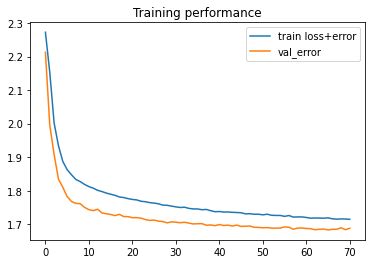

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

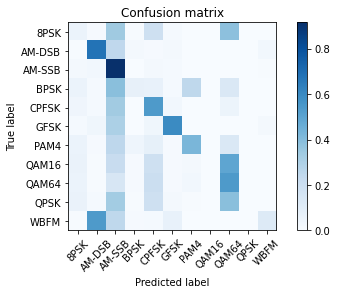

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09044162129461585


Overall Accuracy:  0.08939897311990336


Overall Accuracy:  0.09336535574902431


Overall Accuracy:  0.11254115534271177


Overall Accuracy:  0.12950282822268533


Overall Accuracy:  0.17965895249695493
Overall Accuracy:  0.24591651542649728


Overall Accuracy:  0.32847158918261926


Overall Accuracy:  0.45161290322580644


Overall Accuracy:  0.4768715763846622


Overall Accuracy:  0.4913312693498452


Overall Accuracy:  0.5009030704394943
Overall Accuracy:  0.496594427244582


Overall Accuracy:  0.5010732904017172
Overall Accuracy:  0.49185867895545315


Overall Accuracy:  0.4873035066505441
Overall Accuracy:  0.503793626707132


Overall Accuracy:  0.5092261904761904


Overall Accuracy:  0.4923400420546711


Overall Accuracy:  0.5042708968883466


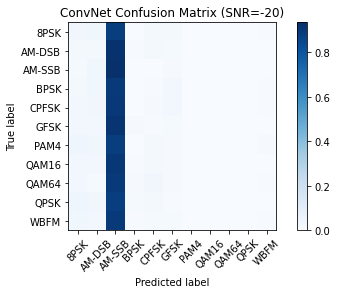

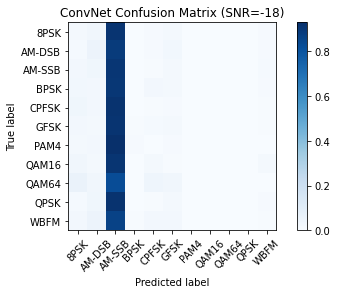

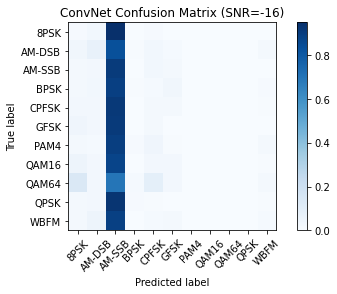

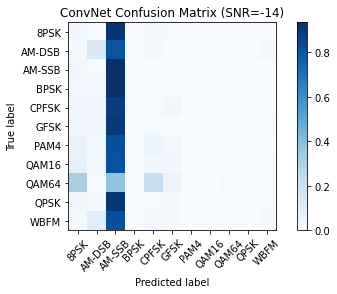

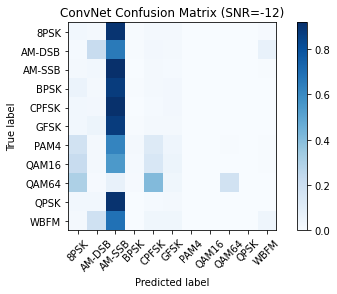

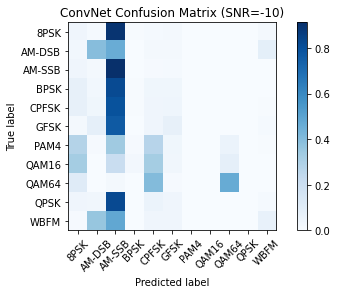

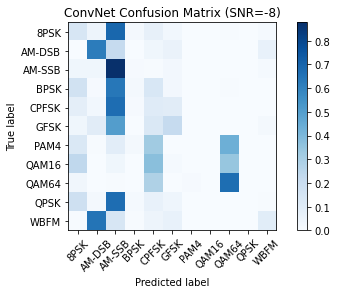

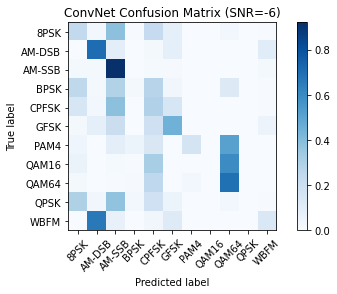

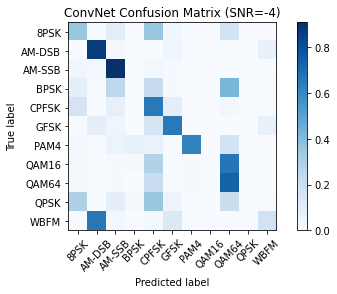

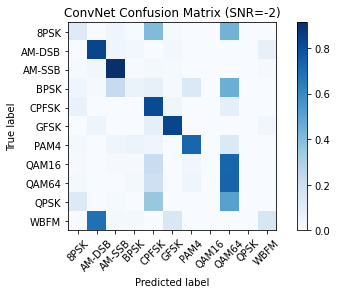

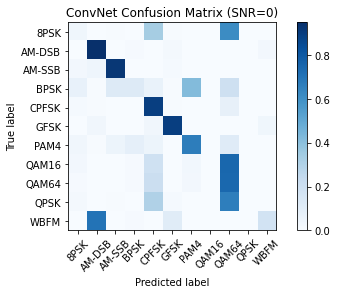

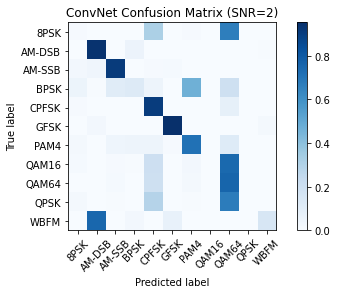

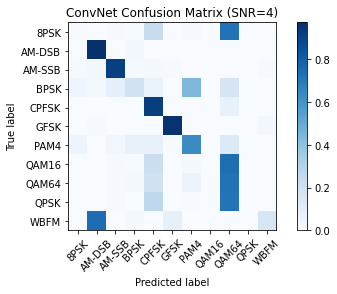

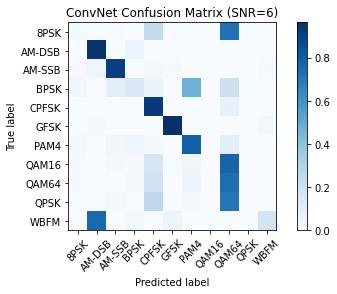

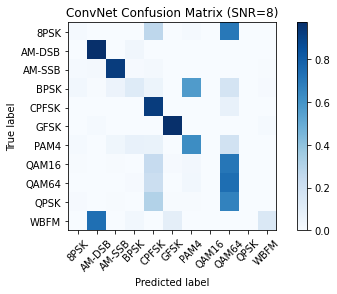

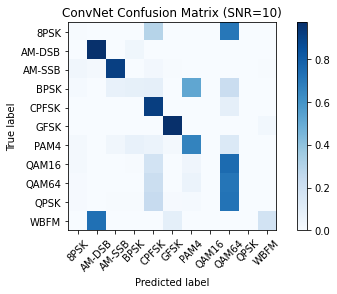

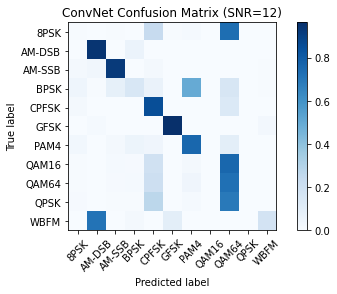

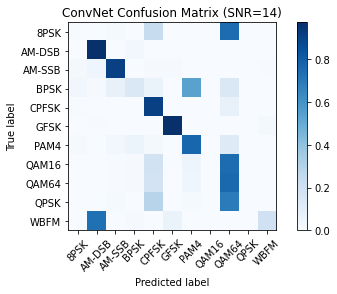

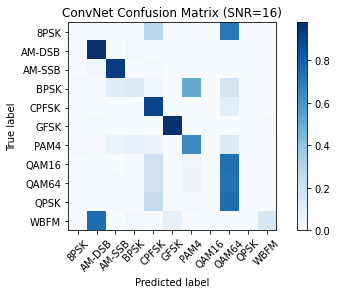

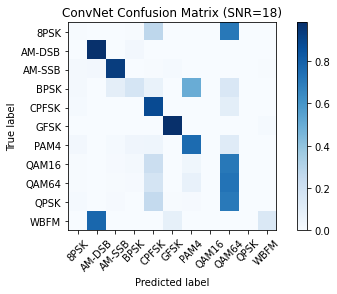

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,8,9,11,12,17,24,32,45,47,49,50,49,50,49,48,50,50,49,50


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

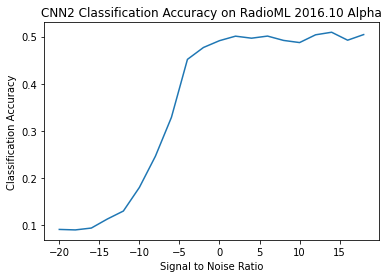

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")